# TFM - CCC PALOS 1 - ENERGY-PRICE CURVE PREDICTION



In this Notebook a PREDICTED ENERGY-PRICE CURVE model will be created.

The following asumptions will be considered:

+ OMIE energy-price curves from November, 2019 to October, 2020 will be considered as the baseline data information. This info comes from the csv file "OMIE_PALOS1.csv", created previously in "TFM_merged-files.ipynb" notebook.


+ As the information in OMIE file does not consider all 12 blocks for every hourly curve, it is created a new dataframe with 12 blocks for all the curves.


+ Only the following information will be considered as features of the models (X):
    * Weekday
    * Period (hour)
    * Energy offered in the block 24h (one day) before the period considered (MWh)
    * Energy offered in the block 168h (one week) before the period considered (MWh)
   NOTE: In further stages of the project, total demanded energy and fuel gas price will be included as features as well. 
   
   
+ The following information will be considered as targets of the models (y):
    * Energy offered in the block (MWh)
    * Price (€/MWh)
    
    
+ The information from the original OMIE information will be split in the following way:
    * TRAIN SET: November, 2019 - August, 2020. (Note that November will have only 3 weeks, since there are no data for the energy offered one week before the first week of the month.)
    * TEST SET: September, 2020
    * VALIDATION SET: October, 2020

In [631]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [632]:
#pd.reset_option('precision')
pd.options.display.float_format = '{:,.2f}'.format

## 2. RETRIEVING, EXPLORING AND PLOTTING OMIE DATA INFORMATION

### 2.1. RETRIEVING DATA INFORMATION

In [633]:
#df will be all data for unit PALOS1 from November 2019 to October 2020. 
#This data was previously created from OMIE web page in "TFM_merged-files.ipynb" notebook.

df = pd.read_csv('/home/dsc/Documents/TFM/Data/OMIE/OMIE_PALOS1/OMIE_PALOS1.csv',index_col=0)

In [634]:
df.head()

,Bid_Code,Num_Version,Bid_Unit,Unit_Description,Sell_Buy,Pot_max,Year,Month,Day,Period,Block,Price,Energy
0,6128191,2,PALOS1,C.C. PALOS 1,VNO,394.10,2020,1,1,1,12,180.30,394.10
1,6128191,2,PALOS1,C.C. PALOS 1,VNO,394.10,2020,1,1,2,12,180.30,394.10
2,6128191,2,PALOS1,C.C. PALOS 1,VNO,394.10,2020,1,1,3,1,1.13,50.00
3,6128191,2,PALOS1,C.C. PALOS 1,VNO,394.10,2020,1,1,3,12,180.30,344.10
4,6128191,2,PALOS1,C.C. PALOS 1,VNO,394.10,2020,1,1,4,1,1.13,60.00


In [635]:
df.shape

(71112, 13)

In [636]:
df.tail()

,Bid_Code,Num_Version,Bid_Unit,Unit_Description,Sell_Buy,Pot_max,Year,Month,Day,Period,Block,Price,Energy
71107,6126741,2,PALOS1,C.C. PALOS 1,VNO,394.10,2019,12,31,24,8,43.22,17.00
71108,6126741,2,PALOS1,C.C. PALOS 1,VNO,394.10,2019,12,31,24,9,44.26,17.00
71109,6126741,2,PALOS1,C.C. PALOS 1,VNO,394.10,2019,12,31,24,10,45.31,17.00
71110,6126741,2,PALOS1,C.C. PALOS 1,VNO,394.10,2019,12,31,24,11,46.35,17.00
71111,6126741,2,PALOS1,C.C. PALOS 1,VNO,394.10,2019,12,31,24,12,180.30,34.10


In [637]:
df.columns

Index(['Bid_Code', 'Num_Version', 'Bid_Unit', 'Unit_Description', 'Sell_Buy',
       'Pot_max', 'Year', 'Month', 'Day', 'Period', 'Block', 'Price',
       'Energy'],
      dtype='object')

In [638]:
df.describe()

,Bid_Code,Num_Version,Pot_max,Year,Month,Day,Period,Block,Price,Energy
count,"71,112.00","71,112.00","71,112.00","71,112.00","71,112.00","71,112.00","71,112.00","71,112.00","71,112.00","71,112.00"
mean,"6,303,430.78",1.78,394.10,"2,019.86",6.36,15.93,15.88,6.52,52.56,47.00
std,"143,155.02",0.87,0.00,0.35,3.43,8.90,5.27,3.64,48.74,75.62
min,"6,049,903.00",1.00,394.10,"2,019.00",1.00,1.00,1.00,1.00,1.13,3.00
25%,"6,176,254.00",1.00,394.10,"2,020.00",3.00,8.00,12.00,3.00,35.40,17.00
50%,"6,300,456.00",2.00,394.10,"2,020.00",6.00,16.00,16.00,6.00,40.72,17.00
75%,"6,427,697.00",2.00,394.10,"2,020.00",9.00,24.00,20.00,10.00,45.42,17.00
max,"6,555,573.00",5.00,394.10,"2,020.00",12.00,31.00,25.00,12.00,180.30,394.10


In [639]:
df.dtypes

Bid_Code              int64
Num_Version           int64
Bid_Unit             object
Unit_Description     object
Sell_Buy             object
Pot_max             float64
Year                  int64
Month                 int64
Day                   int64
Period                int64
Block                 int64
Price               float64
Energy              float64
dtype: object

In [640]:
#Picking only the information that will be needed for ploting the bid curve.

df_curve = df[['Pot_max', 'Year', 'Month', 'Day', 'Period', 'Block', 'Price',
       'Energy']]

In [641]:
df_curve.head()

,Pot_max,Year,Month,Day,Period,Block,Price,Energy
0,394.10,2020,1,1,1,12,180.30,394.10
1,394.10,2020,1,1,2,12,180.30,394.10
2,394.10,2020,1,1,3,1,1.13,50.00
3,394.10,2020,1,1,3,12,180.30,344.10
4,394.10,2020,1,1,4,1,1.13,60.00


In [642]:
#Including date and week day per each day.

import datetime as dt

df_curve['Date']= pd.to_datetime(df_curve[['Year', 'Month', 'Day']])

<ipython-input-642-5b7c39998bb0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_curve['Date']= pd.to_datetime(df_curve[['Year', 'Month', 'Day']])


In [643]:
df_curve.head()

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date
0,394.10,2020,1,1,1,12,180.30,394.10,2020-01-01
1,394.10,2020,1,1,2,12,180.30,394.10,2020-01-01
2,394.10,2020,1,1,3,1,1.13,50.00,2020-01-01
3,394.10,2020,1,1,3,12,180.30,344.10,2020-01-01
4,394.10,2020,1,1,4,1,1.13,60.00,2020-01-01


In [644]:
df_curve['Weekday'] = df_curve['Date'].apply(lambda x: x.weekday())


<ipython-input-644-89fa5e36ee21>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_curve['Weekday'] = df_curve['Date'].apply(lambda x: x.weekday())


In [645]:
df_curve.head()

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday
0,394.10,2020,1,1,1,12,180.30,394.10,2020-01-01,2
1,394.10,2020,1,1,2,12,180.30,394.10,2020-01-01,2
2,394.10,2020,1,1,3,1,1.13,50.00,2020-01-01,2
3,394.10,2020,1,1,3,12,180.30,344.10,2020-01-01,2
4,394.10,2020,1,1,4,1,1.13,60.00,2020-01-01,2


In [646]:
weekDays = ("Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday")

df_curve['Weekday'] = df_curve['Weekday'].apply(lambda x: weekDays[x])

<ipython-input-646-ad44a60512b3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_curve['Weekday'] = df_curve['Weekday'].apply(lambda x: weekDays[x])


In [647]:
df_curve.head()

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday
0,394.10,2020,1,1,1,12,180.30,394.10,2020-01-01,Wednesday
1,394.10,2020,1,1,2,12,180.30,394.10,2020-01-01,Wednesday
2,394.10,2020,1,1,3,1,1.13,50.00,2020-01-01,Wednesday
3,394.10,2020,1,1,3,12,180.30,344.10,2020-01-01,Wednesday
4,394.10,2020,1,1,4,1,1.13,60.00,2020-01-01,Wednesday


In [648]:
#Including the total Energy for all blocks in a certain hour

df_curve['Energy_tot'] = df_curve.groupby(['Date','Period'])['Energy'].cumsum()

<ipython-input-648-59be226ee6af>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_curve['Energy_tot'] = df_curve.groupby(['Date','Period'])['Energy'].cumsum()


In [649]:
df_curve.head()

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
0,394.10,2020,1,1,1,12,180.30,394.10,2020-01-01,Wednesday,394.10
1,394.10,2020,1,1,2,12,180.30,394.10,2020-01-01,Wednesday,394.10
2,394.10,2020,1,1,3,1,1.13,50.00,2020-01-01,Wednesday,50.00
3,394.10,2020,1,1,3,12,180.30,344.10,2020-01-01,Wednesday,394.10
4,394.10,2020,1,1,4,1,1.13,60.00,2020-01-01,Wednesday,60.00


In [650]:
#Storing the DataFrame locally
df_curve.to_csv('/home/dsc/Repos/TFM/PALOS1_DataFrame.csv')

### 2.2. EXPLORING DATA INFORMATION

In [651]:
#Searching for NaN

if df.shape[0] == df.dropna().shape[0]:
    print('No NaN in df')

No NaN in df


In [652]:
#Function created for showing for a certain day and hour of df_curve

def date_hour_info(date, hour):
    return df_curve.sort_values(['Date','Period','Block'])[(df_curve['Date']==date) & 
                                                (df_curve['Period']==hour)]

In [653]:
date_hour_info('2020-10-31',1)

<ipython-input-652-997a6135fd9b>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return df_curve.sort_values(['Date','Period','Block'])[(df_curve['Date']==date) &


,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
60846,394.10,2020,10,31,1,12,180.30,394.10,2020-10-31,Saturday,394.10


In [654]:
date_hour_info('2020-10-31',24)

<ipython-input-652-997a6135fd9b>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return df_curve.sort_values(['Date','Period','Block'])[(df_curve['Date']==date) &


,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
61033,394.10,2020,10,31,24,1,1.13,190.00,2020-10-31,Saturday,190.00
61034,394.10,2020,10,31,24,2,34.89,17.00,2020-10-31,Saturday,207.00
61035,394.10,2020,10,31,24,3,35.64,17.00,2020-10-31,Saturday,224.00
61036,394.10,2020,10,31,24,4,36.40,17.00,2020-10-31,Saturday,241.00
61037,394.10,2020,10,31,24,5,37.15,17.00,2020-10-31,Saturday,258.00
61038,394.10,2020,10,31,24,6,38.71,17.00,2020-10-31,Saturday,275.00
61039,394.10,2020,10,31,24,7,39.46,17.00,2020-10-31,Saturday,292.00
61040,394.10,2020,10,31,24,8,40.22,17.00,2020-10-31,Saturday,309.00
61041,394.10,2020,10,31,24,9,41.47,17.00,2020-10-31,Saturday,326.00
61042,394.10,2020,10,31,24,10,42.73,17.00,2020-10-31,Saturday,343.00


In [655]:
date_hour_info('2020-10-25',1)

<ipython-input-652-997a6135fd9b>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return df_curve.sort_values(['Date','Period','Block'])[(df_curve['Date']==date) &


,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
59640,394.10,2020,10,25,1,12,180.30,394.10,2020-10-25,Sunday,394.10


In [656]:
############# CHECKING DATA FROM df_curve  #############################################

In [657]:
df_curve.shape

(71112, 11)

In [658]:
df_curve[df_curve['Block']==12].shape

(8480, 11)

In [659]:
df_curve[df_curve['Block']==12].shape[0]/24

353.3333333333333

In [660]:
#Something is wrong if the number above is not an integer

In [661]:
from datetime import datetime

first_day = datetime(df_curve['Date'].min().year,
                  df_curve['Date'].min().month,
                  df_curve['Date'].min().day)

last_day = datetime(df_curve['Date'].max().year,
                  df_curve['Date'].max().month,
                  df_curve['Date'].max().day)

In [662]:
#Checking the number of years
num_years = len(df_curve['Year'].value_counts())
num_years

2

In [663]:
#Number of missing years in the original data

num_years_real = (last_day.year - first_day.year) + 1
diff_num_years = num_years_real - num_years
diff_num_years

0

In [664]:
#Checking the number of months in the original data

num_months = len(df_curve[['Year','Month']].value_counts())
num_months

12

In [665]:
#Number of missing months in the original data

num_months_real = (last_day.month -first_day.month) + 12*(last_day.year - first_day.year) + 1
diff_num_months = num_months_real - num_months
diff_num_months

0

In [666]:
#Checking the number of days in the original data

num_days = len(df_curve['Date'].value_counts())
num_days

354

In [667]:
df_curve['Date'].min()

Timestamp('2019-11-01 00:00:00')

In [668]:
df_curve['Date'].max()

Timestamp('2020-10-31 00:00:00')

In [669]:
num_days_real = (last_day - first_day).days + 1
num_days_real

366

In [670]:
#Number of missing days in original data
diff_days = num_days_real - num_days
diff_days

12

In [671]:
#Checking the number of hours in the original data

num_hours_real = num_days_real*24 #It should be checked if within the date range there is an odd number 
                                    #of 23h-day or 25-h-day
num_hours_real


8784

In [672]:
num_hours_orig_real = num_days*24 #It should be checked if within the date range there is an odd number 
                                    #of 23h-day or 25-h-day
num_hours_orig_real

8496

In [673]:
#Checking the number of hours

num_hours = df_curve.groupby(['Date','Period'])['Block'].count().value_counts().sum()
num_hours

8480

In [674]:
#Number of missing hours from the original data
diff_hours = num_hours_real - num_hours
diff_hours

304

In [675]:
#Number of missing hours from the days in the original data
diff_hours_orig = num_hours_orig_real - num_hours
diff_hours_orig

16

In [676]:
#Number of hours per each block. We can see that the only block that appears in all periods is BLOCK 12.
df_curve.groupby(['Block'])['Period'].count()

Block
1     7464
2     5719
3     5719
4     5718
5     5718
6     5444
7     5370
8     5370
9     5370
10    5370
11    5370
12    8480
Name: Period, dtype: int64

In [677]:
df_curve.groupby(['Block'])['Period'].count()[df_curve.groupby(['Block'])['Period'].count() == num_hours]

Block
12    8480
Name: Period, dtype: int64

In [678]:
#Checking that every day has 23, 24 or 25 hours

df_curve_hours = df_curve[(df_curve['Block']==12)].groupby('Date')['Period'].count() #We know that all periods have
                                                                                    #at least the block number 1
df_curve_hours

Date
2019-11-01    24
2019-11-02    24
2019-11-03    24
2019-11-04    24
2019-11-05     8
              ..
2020-10-27    24
2020-10-28    24
2020-10-29    24
2020-10-30    24
2020-10-31    24
Name: Period, Length: 354, dtype: int64

In [679]:
#Number of days with 23h, 24h, 25h or less
df_curve_hours.value_counts()

24    351
25      1
23      1
8       1
Name: Period, dtype: int64

In [680]:
#Day with less than 23 hours
df_curve_hours[(df_curve_hours != 23) & (df_curve_hours != 24) & (df_curve_hours != 25)]

Date
2019-11-05    8
Name: Period, dtype: int64

In [681]:
#Checking data in a period of time
df_curve.loc[df_curve['Date'].isin(['2019-11-05','2019-11-17'])]

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
61889,394.10,2019,11,5,1,12,180.30,394.10,2019-11-05,Tuesday,394.10
61890,394.10,2019,11,5,2,12,180.30,394.10,2019-11-05,Tuesday,394.10
61891,394.10,2019,11,5,3,12,180.30,394.10,2019-11-05,Tuesday,394.10
61892,394.10,2019,11,5,4,12,180.30,394.10,2019-11-05,Tuesday,394.10
61893,394.10,2019,11,5,5,12,180.30,394.10,2019-11-05,Tuesday,394.10
61894,394.10,2019,11,5,6,12,180.30,394.10,2019-11-05,Tuesday,394.10
61895,394.10,2019,11,5,7,12,180.30,394.10,2019-11-05,Tuesday,394.10
61896,394.10,2019,11,5,8,12,180.30,394.10,2019-11-05,Tuesday,394.10


In [682]:
#Searching the days with 23h and 25h within the original data period. 
#It is known that in Spain times changes from 2am to 3am every last Sunday of March and 
#from 3am to 2am every last Sunday of October

from datetime import datetime, timedelta

start_year = df_curve['Year'].min()
end_year = df_curve['Year'].max()

days_23h = []
days_25h = []

for yx in range(start_year,end_year+1):
    
    m_min = df_curve['Month'][df_curve['Year']==yx].min()
    m_max = df_curve['Month'][df_curve['Year']==yx].max()
    
    if 10 in range(m_min,m_max+1):
        October_date = datetime(yx,10,31)
        offset_October = (October_date.weekday() - 6)%7
        last_October_sunday = October_date - timedelta(days=offset_October)
        days_25h += [last_October_sunday]
 
    if 3 in range(m_min,m_max+1):
        March_date = datetime(yx,3,31)
        offset_March = (March_date.weekday() - 6)%7
        last_March_sunday = March_date - timedelta(days=offset_March)
        days_23h += [last_March_sunday]

print(days_25h)
print(days_23h)

[datetime.datetime(2020, 10, 25, 0, 0)]
[datetime.datetime(2020, 3, 29, 0, 0)]


In [683]:
days_25h[0]

datetime.datetime(2020, 10, 25, 0, 0)

In [684]:
#View of some expamples of bids per hour

In [685]:
df_curve[(df_curve['Date']==days_25h[0])&(df_curve['Period'].isin([1,2,3,4,5]))]

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
59640,394.10,2020,10,25,1,12,180.30,394.10,2020-10-25,Sunday,394.10
59641,394.10,2020,10,25,2,12,180.30,394.10,2020-10-25,Sunday,394.10
59642,394.10,2020,10,25,3,12,180.30,394.10,2020-10-25,Sunday,394.10
59643,394.10,2020,10,25,4,1,1.13,75.00,2020-10-25,Sunday,75.00
59644,394.10,2020,10,25,4,12,180.30,319.10,2020-10-25,Sunday,394.10
59645,394.10,2020,10,25,5,1,1.13,120.00,2020-10-25,Sunday,120.00
59646,394.10,2020,10,25,5,12,180.30,274.10,2020-10-25,Sunday,394.10


In [686]:
df_curve[(df_curve['Date']==days_23h[0])&(df_curve['Period'].isin([1,2,3,4,5]))]

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
17862,394.10,2020,3,29,1,12,180.30,394.10,2020-03-29,Sunday,394.10
17863,394.10,2020,3,29,2,12,180.30,394.10,2020-03-29,Sunday,394.10
17864,394.10,2020,3,29,3,12,180.30,394.10,2020-03-29,Sunday,394.10
17865,394.10,2020,3,29,4,1,1.13,75.00,2020-03-29,Sunday,75.00
17866,394.10,2020,3,29,4,12,180.30,319.10,2020-03-29,Sunday,394.10
17867,394.10,2020,3,29,5,1,1.13,120.00,2020-03-29,Sunday,120.00
17868,394.10,2020,3,29,5,12,180.30,274.10,2020-03-29,Sunday,394.10


In [687]:
#View of some expamples of bids per hour

In [688]:
df_curve[(df_curve['Date']==days_25h[0])&(df_curve['Period'].isin([6,7,8]))]

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
59647,394.10,2020,10,25,6,1,1.13,120.00,2020-10-25,Sunday,120.00
59648,394.10,2020,10,25,6,12,180.30,274.10,2020-10-25,Sunday,394.10
59649,394.10,2020,10,25,7,1,1.13,120.00,2020-10-25,Sunday,120.00
59650,394.10,2020,10,25,7,12,180.30,274.10,2020-10-25,Sunday,394.10
59651,394.10,2020,10,25,8,1,1.13,120.00,2020-10-25,Sunday,120.00
59652,394.10,2020,10,25,8,12,180.30,274.10,2020-10-25,Sunday,394.10


In [689]:
df_curve[(df_curve['Date']==days_23h[0])&(df_curve['Period'].isin([6,7,8]))]

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
17869,394.10,2020,3,29,6,1,1.13,120.00,2020-03-29,Sunday,120.00
17870,394.10,2020,3,29,6,12,180.30,274.10,2020-03-29,Sunday,394.10
17871,394.10,2020,3,29,7,1,1.13,120.00,2020-03-29,Sunday,120.00
17872,394.10,2020,3,29,7,12,180.30,274.10,2020-03-29,Sunday,394.10
17873,394.10,2020,3,29,8,1,1.13,120.00,2020-03-29,Sunday,120.00
17874,394.10,2020,3,29,8,12,180.30,274.10,2020-03-29,Sunday,394.10


In [690]:
df_curve[(df_curve['Date']==days_25h[0])&(df_curve['Period'].isin([9,10]))]

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
59653,394.10,2020,10,25,9,1,1.13,190.00,2020-10-25,Sunday,190.00
59654,394.10,2020,10,25,9,2,38.27,17.00,2020-10-25,Sunday,207.00
59655,394.10,2020,10,25,9,3,39.10,17.00,2020-10-25,Sunday,224.00
59656,394.10,2020,10,25,9,4,39.93,17.00,2020-10-25,Sunday,241.00
59657,394.10,2020,10,25,9,5,40.76,14.00,2020-10-25,Sunday,255.00
59658,394.10,2020,10,25,9,12,180.30,139.10,2020-10-25,Sunday,394.10
59659,394.10,2020,10,25,10,1,1.13,190.00,2020-10-25,Sunday,190.00
59660,394.10,2020,10,25,10,2,38.27,17.00,2020-10-25,Sunday,207.00
59661,394.10,2020,10,25,10,3,39.10,17.00,2020-10-25,Sunday,224.00
59662,394.10,2020,10,25,10,4,39.93,17.00,2020-10-25,Sunday,241.00


In [691]:
df_curve[(df_curve['Date']==days_23h[0])&(df_curve['Period'].isin([9,10]))]

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
17875,394.10,2020,3,29,9,1,1.13,190.00,2020-03-29,Sunday,190.00
17876,394.10,2020,3,29,9,2,41.06,17.00,2020-03-29,Sunday,207.00
17877,394.10,2020,3,29,9,3,42.20,17.00,2020-03-29,Sunday,224.00
17878,394.10,2020,3,29,9,4,43.34,17.00,2020-03-29,Sunday,241.00
17879,394.10,2020,3,29,9,5,44.48,14.00,2020-03-29,Sunday,255.00
17880,394.10,2020,3,29,9,12,180.30,139.10,2020-03-29,Sunday,394.10
17881,394.10,2020,3,29,10,1,1.13,190.00,2020-03-29,Sunday,190.00
17882,394.10,2020,3,29,10,2,41.06,17.00,2020-03-29,Sunday,207.00
17883,394.10,2020,3,29,10,3,42.20,17.00,2020-03-29,Sunday,224.00
17884,394.10,2020,3,29,10,4,43.34,17.00,2020-03-29,Sunday,241.00


In [692]:
############ CELLS BELOW UP TO POINT 2.3 SHOULD BE DELETED ####################

In [693]:
#Checking the number or hours per date
df_curve.groupby(['Year','Month','Day'])['Period'].count()

Year  Month  Day
2019  11     1      211
             2      211
             3      211
             4      211
             5        8
                   ... 
2020  10     27     199
             28     199
             29     199
             30     199
             31     199
Name: Period, Length: 354, dtype: int64

In [694]:
df_curve[['Year','Month','Day','Period','Block']][(df_curve['Period']==24)&
                                                  (df_curve['Block']==12)].value_counts('Day')

Day
1     12
23    12
4     12
3     12
18    12
19    12
20    12
22    12
21    12
24    12
25    12
26    12
27    12
28    12
2     12
10    11
5     11
6     11
7     11
8     11
9     11
16    11
11    11
12    11
13    11
14    11
15    11
30    11
17    11
29    11
31     7
dtype: int64

In [695]:
df_curve[['Year','Month','Day','Period','Block']][(df_curve['Period']==24)&
                                                  (df_curve['Block']==12)&
                                                  (df_curve['Day']==2)]

,Year,Month,Day,Period,Block
421,2020,1,2,24,12
6916,2020,2,2,24,12
12687,2020,3,2,24,12
18844,2020,4,2,24,12
24814,2020,5,2,24,12
30983,2020,6,2,24,12
36953,2020,7,2,24,12
43122,2020,8,2,24,12
49291,2020,9,2,24,12
55261,2020,10,2,24,12


In [696]:
df_curve[['Year','Month','Day','Period','Block']][(df_curve['Period']==24)&
                                                  (df_curve['Block']==12)&
                                                  (df_curve['Month']==11)]

,Year,Month,Day,Period,Block
61255,2019,11,1,24,12
61466,2019,11,2,24,12
61677,2019,11,3,24,12
61888,2019,11,4,24,12
62107,2019,11,18,24,12
62264,2019,11,19,24,12
62466,2019,11,20,24,12
62678,2019,11,21,24,12
62890,2019,11,22,24,12
63094,2019,11,23,24,12


In [697]:
df_curve[['Year','Month','Day','Period','Block']][(df_curve['Period']==24)&
                                                  (df_curve['Block']==12)&
                                                  (df_curve['Month']==11)].shape

(17, 5)

In [698]:
17*24

408

In [699]:
df_curve[['Year','Month','Day','Period','Block']][(df_curve['Block']==12)&
                                                  (df_curve['Month']==11)].shape

(416, 5)

In [700]:
df_curve[['Year','Month','Day','Period','Block']][(df_curve['Period']==24)&
                                                  (df_curve['Block']==12)&
                                                  (df_curve['Day']==5)]

,Year,Month,Day,Period,Block
1054,2020,1,5,24,12
7513,2020,2,5,24,12
13284,2020,3,5,24,12
19441,2020,4,5,24,12
25411,2020,5,5,24,12
31580,2020,6,5,24,12
37550,2020,7,5,24,12
43719,2020,8,5,24,12
49888,2020,9,5,24,12
55858,2020,10,5,24,12


In [701]:
#Checking the number or blocks per date and period
df_curve.groupby(['Year','Month','Day','Period'])['Block'].count()

Year  Month  Day  Period
2019  11     1    1          1
                  2          1
                  3          2
                  4          2
                  5          2
                            ..
2020  10     31   20        12
                  21        12
                  22        12
                  23        12
                  24        12
Name: Block, Length: 8480, dtype: int64

In [702]:
#Checking the number of hours with a certain number of blocks. It can be seen that most of them have 12 blocks,
#but there are a lot of hours with only one or two blocks.
df_curve.groupby(['Year','Month','Day','Period'])['Block'].count().value_counts()

12    5370
2     1745
1     1016
6      274
7       74
4        1
Name: Block, dtype: int64

In [703]:
#Checking the number of hours in one year
len(df_curve.groupby(['Year','Month','Day','Period'])['Block'].count())

8480

In [704]:
len(df_curve.groupby(['Year','Month','Day','Period'])['Block'].count())/24

353.3333333333333

In [705]:
#Number of missing days
365 -len(df_curve.groupby(['Year','Month','Day','Period'])['Block'].count())/24

11.666666666666686

In [706]:
df_curve.groupby(['Month','Day','Period'])['Block'].count().value_counts().sum()

8480

In [707]:
len(df_curve)

71112

In [708]:
df_curve[['Month','Day','Block']].groupby(['Block']).count()

,Month,Day
Block,,
1,7464,7464
2,5719,5719
3,5719,5719
4,5718,5718
5,5718,5718
6,5444,5444
7,5370,5370
8,5370,5370
9,5370,5370


In [709]:
df_curve[['Month','Day','Block']].groupby(['Block']).count().sum()

Month    71112
Day      71112
dtype: int64

In [710]:
df_curve.head()

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
0,394.10,2020,1,1,1,12,180.30,394.10,2020-01-01,Wednesday,394.10
1,394.10,2020,1,1,2,12,180.30,394.10,2020-01-01,Wednesday,394.10
2,394.10,2020,1,1,3,1,1.13,50.00,2020-01-01,Wednesday,50.00
3,394.10,2020,1,1,3,12,180.30,344.10,2020-01-01,Wednesday,394.10
4,394.10,2020,1,1,4,1,1.13,60.00,2020-01-01,Wednesday,60.00


### 2.3. PLOTTING DATA INFORMATION

In [711]:
#Function to plot original bid curves for a chosen date and period (hour)

def plot_bid_curve(date, hour):
    df_plot = df_curve.sort_values(['Date','Period','Block'])[(df_curve['Date'] == date) & 
                                                (df_curve['Period'] == hour)]
    return plt.plot(pd.Series(0).append(df_plot['Energy_tot']), 
                    pd.Series(df_plot['Price'].iloc[0]).append(df_plot['Price']), 
                    drawstyle='steps', 
                    label='steps (=steps-pre)')

<ipython-input-711-5c36c8e17e7e>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_plot = df_curve.sort_values(['Date','Period','Block'])[(df_curve['Date'] == date) &


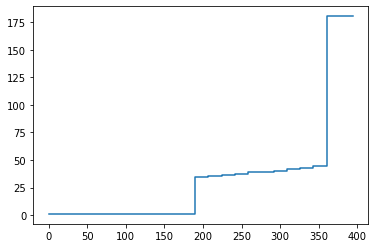

In [712]:
plot_bid_curve('2020-10-31', 24)

<ipython-input-711-5c36c8e17e7e>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_plot = df_curve.sort_values(['Date','Period','Block'])[(df_curve['Date'] == date) &


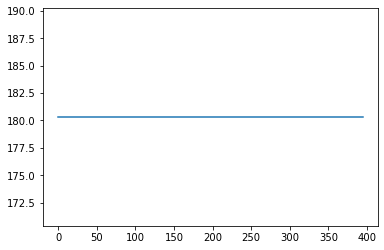

In [713]:
plot_bid_curve('2020-10-31', 1)

<ipython-input-711-5c36c8e17e7e>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_plot = df_curve.sort_values(['Date','Period','Block'])[(df_curve['Date'] == date) &


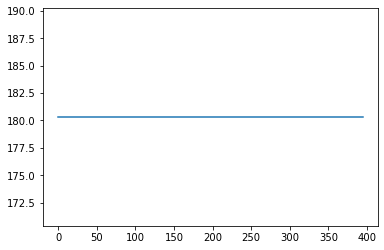

In [714]:
plot_bid_curve('2020-8-25', 1)

<ipython-input-711-5c36c8e17e7e>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_plot = df_curve.sort_values(['Date','Period','Block'])[(df_curve['Date'] == date) &


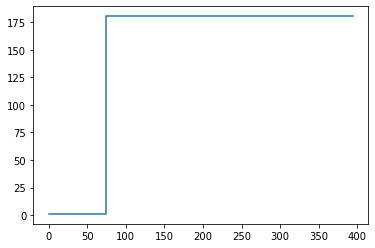

In [715]:
plot_bid_curve('2020-8-25',4)

<ipython-input-711-5c36c8e17e7e>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_plot = df_curve.sort_values(['Date','Period','Block'])[(df_curve['Date'] == date) &


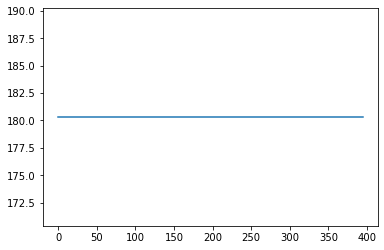

In [716]:
plot_bid_curve('2019-11-5',4)

In [717]:
df_curve.sort_values(['Date','Period','Block'])[(df_curve['Date'] == '2019-11-9') & 
                                                (df_curve['Period'] == 4)]

<ipython-input-717-73d4b59b249c>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_curve.sort_values(['Date','Period','Block'])[(df_curve['Date'] == '2019-11-9') &


,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot


## 3. DATA WRANGLING

### 3.1. CREATING A NEW DATAFRAME WITH ALL BLOCKS PER EACH HOUR

In this section a new dataframe will be created from the original one by completing the information por every hour that does not have all blocks (12). 

It is important to point out that in the original dataframe does not have 12 blocks per each hour (or period), since not always is necessary in the biding curve. In order to use the information in the models that will be created, it is important that every hour is divided in 12 blocks. 

As the original dataframe does not have all days and hours for a given period, it is decided to create a new dataframe equal to the original one (only for dates, hours and blocks) but with all 12 blocks per each hour in the orignal data.

The new dataframe is created considering a df structure for 1 Block and then copy this new df, changing the number of the block and appending it to the original. The correct structure of the df will be created by doing it 12 times.

Then this new dataframe will be merged with the original one so NaN will be created for all the columns without blocks in the original dataframe. This NaN will be filled depending on each case.

In [718]:
#Checking blocks for one day
date_hour_info('2020-10-22',9)

<ipython-input-652-997a6135fd9b>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return df_curve.sort_values(['Date','Period','Block'])[(df_curve['Date']==date) &


,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
59056,394.10,2020,10,22,9,1,1.13,190.00,2020-10-22,Thursday,190.00
59057,394.10,2020,10,22,9,2,35.34,17.00,2020-10-22,Thursday,207.00
59058,394.10,2020,10,22,9,3,36.11,17.00,2020-10-22,Thursday,224.00
59059,394.10,2020,10,22,9,4,36.87,17.00,2020-10-22,Thursday,241.00
59060,394.10,2020,10,22,9,5,37.64,14.00,2020-10-22,Thursday,255.00
59061,394.10,2020,10,22,9,12,180.30,139.10,2020-10-22,Thursday,394.10


### 3.1.1. MODIFYING THE ORIGINAL DATAFRAME TO REMOVE DAYS WITH 23H AND 25H


In [719]:
#New dataframe is created considering 24h for all days
df_curve_24h = df_curve.copy()

In [720]:
#Using 23h-days and 25h-days from previous sections

In [721]:
#Funtions needed for renaming periods in 23h-days and 25h-days.

def change_25h_to24h(x):
    if x >= 4:
        x -= 1
    return x

def change_23h_to24h(x):
    if x >= 2:
        x += 1
    return x

In [722]:
#Transforming 25h-day into 24h-day.

for date_25h in days_25h:
    #dataframe only with 25h-day data
    df_curve_day25h = df_curve_24h[df_curve_24h['Date']==date_25h]
    #Deleting period 3 from 25h-days.
    df_curve_day25h = df_curve_day25h.drop(df_curve_day25h.loc[df_curve_day25h['Period']==3].index)
    #Renaming periods from 4 to 25 to 3 to 24
    df_curve_day25h['Period'] = df_curve_day25h['Period'].apply(change_25h_to24h)
    df_curve_24h = df_curve_24h.drop(df_curve_24h[df_curve_24h['Date']==date_25h].index)
    df_curve_24h = pd.concat([df_curve_24h,df_curve_day25h])

In [723]:
#Transforming 23h-day into 24h-day.

for date_23h in days_23h:
    df_curve_day23h = df_curve_24h[df_curve_24h['Date']==date_23h]
    #Renaming periods from 2 to 23 to 3 to 24
    df_curve_day23h['Period'] = df_curve_day23h['Period'].apply(change_23h_to24h)
    #Copying period 1 as period 2 and renaming it
    df_curve_day23h_period1 = df_curve_day23h[(df_curve_day23h['Date']==date_23h)&(df_curve_day23h['Period']==1)]
    df_curve_day23h_period1['Period'] = df_curve_day23h_period1['Period'].apply(lambda x: x+1)
    df_curve_day23h = df_curve_day23h.append(df_curve_day23h_period1, ignore_index=True)
    df_curve_24h = df_curve_24h.drop(df_curve_24h[df_curve_24h['Date']==date_23h].index)
    df_curve_24h = pd.concat([df_curve_24h,df_curve_day23h])

<ipython-input-723-377225477582>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_curve_day23h['Period'] = df_curve_day23h['Period'].apply(change_23h_to24h)
<ipython-input-723-377225477582>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_curve_day23h_period1['Period'] = df_curve_day23h_period1['Period'].apply(lambda x: x+1)


In [724]:
df_curve_24h = df_curve_24h.sort_values(['Date','Period','Block']).reset_index(drop=True)
df_curve_24h

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
0,394.10,2019,11,1,1,12,180.30,394.10,2019-11-01,Friday,394.10
1,394.10,2019,11,1,2,12,180.30,394.10,2019-11-01,Friday,394.10
2,394.10,2019,11,1,3,1,1.13,50.00,2019-11-01,Friday,50.00
3,394.10,2019,11,1,3,12,180.30,344.10,2019-11-01,Friday,394.10
4,394.10,2019,11,1,4,1,1.13,60.00,2019-11-01,Friday,60.00
...,...,...,...,...,...,...,...,...,...,...,...
71107,394.10,2020,10,31,24,8,40.22,17.00,2020-10-31,Saturday,309.00
71108,394.10,2020,10,31,24,9,41.47,17.00,2020-10-31,Saturday,326.00
71109,394.10,2020,10,31,24,10,42.73,17.00,2020-10-31,Saturday,343.00
71110,394.10,2020,10,31,24,11,44.48,17.00,2020-10-31,Saturday,360.00


In [725]:
df_curve_24h.shape, df_curve.shape

((71112, 11), (71112, 11))

### 3.1.2. CREATING AN EMPTY DATAFRAME WITH THE SAME DATA STRUCTURE OF THE ORIGINAL

#### 3.1.2.1. CREATING AN EMPTY DATAFRAME WITH THE SAME DATA STRUCTURE OF THE ORIGINAL

In [726]:
#Creating a new df with the same structure of the orinal. 
#First of all, it is choosen from the orininal df the information from the date, hours and ONE block.
#Block number 12 is choosen as it is the only block that it is in all the hour.

df_block = df_curve[['Year','Month','Day','Period','Block']][df_curve['Block']==12].reset_index(drop=True)
df_block.head()

,Year,Month,Day,Period,Block
0,2020,1,1,1,12
1,2020,1,1,2,12
2,2020,1,1,3,12
3,2020,1,1,4,12
4,2020,1,1,5,12


In [727]:
df_block.shape

(8480, 5)

In [728]:
#Number of row that should have the new dataframe.

df_block.shape[0]*12

101760

In [729]:
#Changing the value of all Blocks to 1
df_block['Block'] = 1

In [730]:
df_block.head()

,Year,Month,Day,Period,Block
0,2020,1,1,1,1
1,2020,1,1,2,1
2,2020,1,1,3,1
3,2020,1,1,4,1
4,2020,1,1,5,1


In [731]:
#Creating a new dataframe with the same structure for all Blocks

df_block_tot = pd.DataFrame()

for block in range(1,13):
    df_block_new = df_block.copy()
    df_block_new['Block'] = block
    df_block_tot = pd.concat([df_block_tot,df_block_new])

In [732]:
df_block_tot

,Year,Month,Day,Period,Block
0,2020,1,1,1,1
1,2020,1,1,2,1
2,2020,1,1,3,1
3,2020,1,1,4,1
4,2020,1,1,5,1
...,...,...,...,...,...
8475,2019,12,31,20,12
8476,2019,12,31,21,12
8477,2019,12,31,22,12
8478,2019,12,31,23,12


In [733]:
df_block_tot.reset_index(inplace=True,drop=True)

In [734]:
df_block_tot

,Year,Month,Day,Period,Block
0,2020,1,1,1,1
1,2020,1,1,2,1
2,2020,1,1,3,1
3,2020,1,1,4,1
4,2020,1,1,5,1
...,...,...,...,...,...
101755,2019,12,31,20,12
101756,2019,12,31,21,12
101757,2019,12,31,22,12
101758,2019,12,31,23,12


In [735]:
len(df_block_tot) == df_block.shape[0]*12

True

#### 3.1.2.2. CREATING AN EMPTY DATAFRAME WITH THE SAME DATA STRUCTURE OF THE ORIGINAL (without 23h-days & 25h-days)

In [736]:
#Creating a new df with the same structure of the orinal one, without 23h and 25h-days. 
#First of all, it is choosen from the orininal df the information from the date, hours and ONE block.
#Block number 12 is choosen as it is the only block that it is in all the hour.

df_block_24h = df_curve_24h[['Year','Month','Day','Period','Block']][df_curve_24h['Block']==12].reset_index(drop=True)

#Changing the value of all Blocks to 1
df_block_24h['Block'] = 1

#Creating a new dataframe with the same structure for all Blocks
df_block_tot_24h = pd.DataFrame()

for block_24h in range(1,13):
    df_block_new_24h = df_block_24h.copy()
    df_block_new_24h['Block'] = block_24h
    df_block_tot_24h = pd.concat([df_block_tot_24h,df_block_new_24h])
    

df_block_tot_24h.reset_index(inplace=True,drop=True)

In [737]:
len(df_block_tot_24h) == df_block_24h.shape[0]*12

True

In [738]:
df_block_tot_24h.shape

(101760, 5)

### 3.1.3. CREATING AN NEW DATAFRAME WITH ALL BLOCKS PER EACH HOUR

#### 3.1.3.1. CREATING AN NEW DATAFRAME WITH ALL BLOCKS PER EACH HOUR

In [739]:
#Now the complete dataframe is created by merging the original df (df_curve) with the new structure dataframe 
#created (df_block_tot)

df_tot = df_curve.merge(df_block_tot,how='outer')

In [740]:
df_tot.head(15)

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
0,394.10,2020,1,1,1,12,180.30,394.10,2020-01-01,Wednesday,394.10
1,394.10,2020,1,1,2,12,180.30,394.10,2020-01-01,Wednesday,394.10
2,394.10,2020,1,1,3,1,1.13,50.00,2020-01-01,Wednesday,50.00
3,394.10,2020,1,1,3,12,180.30,344.10,2020-01-01,Wednesday,394.10
4,394.10,2020,1,1,4,1,1.13,60.00,2020-01-01,Wednesday,60.00
5,394.10,2020,1,1,4,12,180.30,334.10,2020-01-01,Wednesday,394.10
6,394.10,2020,1,1,5,1,1.13,60.00,2020-01-01,Wednesday,60.00
7,394.10,2020,1,1,5,12,180.30,334.10,2020-01-01,Wednesday,394.10
8,394.10,2020,1,1,6,1,1.13,60.00,2020-01-01,Wednesday,60.00
9,394.10,2020,1,1,6,12,180.30,334.10,2020-01-01,Wednesday,394.10


In [741]:
#New dataframe is sorted and reseted index
df_tot = df_tot.sort_values(['Year','Month','Day','Period','Block']).reset_index(drop=True)
df_tot.head(15)

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
0,nan,2019,11,1,1,1,nan,nan,NaT,NaN,nan
1,nan,2019,11,1,1,2,nan,nan,NaT,NaN,nan
2,nan,2019,11,1,1,3,nan,nan,NaT,NaN,nan
3,nan,2019,11,1,1,4,nan,nan,NaT,NaN,nan
4,nan,2019,11,1,1,5,nan,nan,NaT,NaN,nan
5,nan,2019,11,1,1,6,nan,nan,NaT,NaN,nan
6,nan,2019,11,1,1,7,nan,nan,NaT,NaN,nan
7,nan,2019,11,1,1,8,nan,nan,NaT,NaN,nan
8,nan,2019,11,1,1,9,nan,nan,NaT,NaN,nan
9,nan,2019,11,1,1,10,nan,nan,NaT,NaN,nan


In [742]:
#As the structrue dataframe has more rows that the original, a lot of NaN have been created.
#These NaN must be filled.

In [743]:
#As Block 12 is always in the original dataframe and dataframe is sorted by 'Block', bfill is the
#right method to fill NaN since the meaning of no Block in OMIE curve is a fixed Price.
df_tot['Price'].fillna(method='bfill',inplace=True)

In [744]:
#Pot_max is allways the same value
df_tot['Pot_max'].fillna(df_tot['Pot_max'].max(),inplace=True)

In [745]:
#For the same reason of Price, Weekday is filled with bfill method
df_tot['Weekday'].fillna(method='bfill',inplace=True)

In [746]:
#For the same reason of Price, Datw is filled with bfill method
df_tot['Date'].fillna(method='bfill',inplace=True)

In [747]:
#Energy NaN will be filled with 0 since allways Energy of Block 12 must be Pot_max (394.1)
df_tot['Energy'].fillna(float(0),inplace=True)

In [748]:
df_tot.head(15)

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
0,394.10,2019,11,1,1,1,180.30,0.00,2019-11-01,Friday,nan
1,394.10,2019,11,1,1,2,180.30,0.00,2019-11-01,Friday,nan
2,394.10,2019,11,1,1,3,180.30,0.00,2019-11-01,Friday,nan
3,394.10,2019,11,1,1,4,180.30,0.00,2019-11-01,Friday,nan
4,394.10,2019,11,1,1,5,180.30,0.00,2019-11-01,Friday,nan
5,394.10,2019,11,1,1,6,180.30,0.00,2019-11-01,Friday,nan
6,394.10,2019,11,1,1,7,180.30,0.00,2019-11-01,Friday,nan
7,394.10,2019,11,1,1,8,180.30,0.00,2019-11-01,Friday,nan
8,394.10,2019,11,1,1,9,180.30,0.00,2019-11-01,Friday,nan
9,394.10,2019,11,1,1,10,180.30,0.00,2019-11-01,Friday,nan


In [749]:
#Now only Energy_tot columns have NaN
#NaN in Energy_tot can be filled by interpolation method, but first of all a value must be included
#in all cells with Block number equal to 1, since it is necessary 2 values in each Period to be able to 
#interpolate and it is the only way to fill NaN in all Periods with only one Block (12)

In [750]:
#Problem with Periods with only Block 12
df_tot['Energy_tot'].interpolate()

0           nan
1           nan
2           nan
3           nan
4           nan
          ...  
101755   309.00
101756   326.00
101757   343.00
101758   360.00
101759   394.10
Name: Energy_tot, Length: 101760, dtype: float64

In [751]:
df_tot.iloc[:50]

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
0,394.10,2019,11,1,1,1,180.30,0.00,2019-11-01,Friday,nan
1,394.10,2019,11,1,1,2,180.30,0.00,2019-11-01,Friday,nan
2,394.10,2019,11,1,1,3,180.30,0.00,2019-11-01,Friday,nan
3,394.10,2019,11,1,1,4,180.30,0.00,2019-11-01,Friday,nan
4,394.10,2019,11,1,1,5,180.30,0.00,2019-11-01,Friday,nan
5,394.10,2019,11,1,1,6,180.30,0.00,2019-11-01,Friday,nan
6,394.10,2019,11,1,1,7,180.30,0.00,2019-11-01,Friday,nan
7,394.10,2019,11,1,1,8,180.30,0.00,2019-11-01,Friday,nan
8,394.10,2019,11,1,1,9,180.30,0.00,2019-11-01,Friday,nan
9,394.10,2019,11,1,1,10,180.30,0.00,2019-11-01,Friday,nan


In [752]:
#Minimum value in Energy_tot column
df_tot['Energy_tot'].min()

50.0

In [753]:
df_tot['Energy_tot'][df_tot['Block']==1].min()

50.0

In [754]:
#We will replace only NaN in Energy_tot for Block = 1 with 50 (min)

In [755]:
df_tot['Energy_tot'][df_tot['Block']==1]

0           nan
12          nan
24        50.00
36        60.00
48        60.00
          ...  
101700   190.00
101712   190.00
101724   190.00
101736   190.00
101748   190.00
Name: Energy_tot, Length: 8480, dtype: float64

In [756]:
#Filling Energy_tot NaN for Block=1 with 50

df_tot['Energy_tot'][(df_tot['Block']==1) & 
                     (df_tot['Energy_tot'].isnull())] = df_tot['Energy_tot'][df_tot['Block']==1].min()

<ipython-input-756-eb08c985814b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tot['Energy_tot'][(df_tot['Block']==1) &


In [757]:
df_tot.head(15)

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
0,394.10,2019,11,1,1,1,180.30,0.00,2019-11-01,Friday,50.00
1,394.10,2019,11,1,1,2,180.30,0.00,2019-11-01,Friday,nan
2,394.10,2019,11,1,1,3,180.30,0.00,2019-11-01,Friday,nan
3,394.10,2019,11,1,1,4,180.30,0.00,2019-11-01,Friday,nan
4,394.10,2019,11,1,1,5,180.30,0.00,2019-11-01,Friday,nan
5,394.10,2019,11,1,1,6,180.30,0.00,2019-11-01,Friday,nan
6,394.10,2019,11,1,1,7,180.30,0.00,2019-11-01,Friday,nan
7,394.10,2019,11,1,1,8,180.30,0.00,2019-11-01,Friday,nan
8,394.10,2019,11,1,1,9,180.30,0.00,2019-11-01,Friday,nan
9,394.10,2019,11,1,1,10,180.30,0.00,2019-11-01,Friday,nan


In [758]:
#Cheching that everything is OK between original dataframe and new one

df_curve[['Block','Energy_tot']] [df_curve['Block']==1].value_counts()

Block  Energy_tot
1      190.00        5719
       120.00        1096
       75.00          274
       60.00          221
       50.00           75
       70.00           73
       102.00           3
       145.00           1
       65.00            1
       55.00            1
dtype: int64

In [759]:
df_tot[['Block','Energy_tot']] [df_tot['Block']==1].value_counts()

Block  Energy_tot
1      190.00        5719
       120.00        1096
       50.00         1091
       75.00          274
       60.00          221
       70.00           73
       102.00           3
       145.00           1
       65.00            1
       55.00            1
dtype: int64

In [760]:
#It is OK since the only modification is 50 that goes from 75 to 1091

In [761]:
#Now remaining NaN in Energy_tot are filled by interpolation 

df_tot['Energy_tot'].interpolate(inplace=True)

In [762]:
df_tot.head(20)

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
0,394.10,2019,11,1,1,1,180.30,0.00,2019-11-01,Friday,50.00
1,394.10,2019,11,1,1,2,180.30,0.00,2019-11-01,Friday,81.28
2,394.10,2019,11,1,1,3,180.30,0.00,2019-11-01,Friday,112.56
3,394.10,2019,11,1,1,4,180.30,0.00,2019-11-01,Friday,143.85
4,394.10,2019,11,1,1,5,180.30,0.00,2019-11-01,Friday,175.13
5,394.10,2019,11,1,1,6,180.30,0.00,2019-11-01,Friday,206.41
6,394.10,2019,11,1,1,7,180.30,0.00,2019-11-01,Friday,237.69
7,394.10,2019,11,1,1,8,180.30,0.00,2019-11-01,Friday,268.97
8,394.10,2019,11,1,1,9,180.30,0.00,2019-11-01,Friday,300.25
9,394.10,2019,11,1,1,10,180.30,0.00,2019-11-01,Friday,331.54


In [763]:
df_tot.shape

(101760, 11)

In [764]:
df_tot.to_csv('/home/dsc/Repos/TFM/df_tot.csv')

#### 3.1.3.2. CREATING AN NEW DATAFRAME WITH ALL BLOCKS PER EACH HOUR (without 23h and 25h-days)

In [765]:
#Now the complete dataframe is created by merging the original df (df_curve) with the new structure dataframe 
#created (df_block_tot)

df_tot_24h = df_curve_24h.merge(df_block_tot_24h,how='outer')

#New dataframe is sorted and reseted index
df_tot_24h = df_tot_24h.sort_values(['Year','Month','Day','Period','Block']).reset_index(drop=True)

#As the structrue dataframe has more rows that the original, a lot of NaN have been created.
#These NaN must be filled.

#As Block 12 is always in the original dataframe and dataframe is sorted by 'Block', bfill is the
#right method to fill NaN since the meaning of no Block in OMIE curve is a fixed Price.
df_tot_24h['Price'].fillna(method='bfill',inplace=True)

#Pot_max is allways the same value
df_tot_24h['Pot_max'].fillna(df_tot_24h['Pot_max'].max(),inplace=True)

#For the same reason of Price, Weekday is filled with bfill method
df_tot_24h['Weekday'].fillna(method='bfill',inplace=True)

#For the same reason of Price, Datw is filled with bfill method
df_tot_24h['Date'].fillna(method='bfill',inplace=True)

#Energy NaN will be filled with 0 since allways Energy of Block 12 must be Pot_max (394.1)
df_tot_24h['Energy'].fillna(float(0),inplace=True)

#Now only Energy_tot columns have NaN
#NaN in Energy_tot can be filled by interpolation method, but first of all a value must be included
#in all cells with Block number equal to 1, since it is necessary 2 values in each Period to be able to 
#interpolate and it is the only way to fill NaN in all Periods with only one Block (12)

#Filling Energy_tot NaN for Block=1 with 50
df_tot_24h['Energy_tot'][(df_tot_24h['Block']==1) & 
                     (df_tot_24h['Energy_tot'].isnull())] = df_tot_24h['Energy_tot'][df_tot_24h['Block']==1].min()

#Now remaining NaN in Energy_tot are filled by interpolation 
df_tot_24h['Energy_tot'].interpolate(inplace=True)

<ipython-input-765-426908049f2c>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tot_24h['Energy_tot'][(df_tot_24h['Block']==1) &


In [766]:
df_tot_24h.head(15)

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
0,394.10,2019,11,1,1,1,180.30,0.00,2019-11-01,Friday,50.00
1,394.10,2019,11,1,1,2,180.30,0.00,2019-11-01,Friday,81.28
2,394.10,2019,11,1,1,3,180.30,0.00,2019-11-01,Friday,112.56
3,394.10,2019,11,1,1,4,180.30,0.00,2019-11-01,Friday,143.85
4,394.10,2019,11,1,1,5,180.30,0.00,2019-11-01,Friday,175.13
5,394.10,2019,11,1,1,6,180.30,0.00,2019-11-01,Friday,206.41
6,394.10,2019,11,1,1,7,180.30,0.00,2019-11-01,Friday,237.69
7,394.10,2019,11,1,1,8,180.30,0.00,2019-11-01,Friday,268.97
8,394.10,2019,11,1,1,9,180.30,0.00,2019-11-01,Friday,300.25
9,394.10,2019,11,1,1,10,180.30,0.00,2019-11-01,Friday,331.54


In [767]:
#Cheching that everything is OK between original dataframe and new one

df_curve[['Block','Energy_tot']] [df_curve['Block']==1].value_counts()

Block  Energy_tot
1      190.00        5719
       120.00        1096
       75.00          274
       60.00          221
       50.00           75
       70.00           73
       102.00           3
       145.00           1
       65.00            1
       55.00            1
dtype: int64

In [768]:
df_tot_24h[['Block','Energy_tot']] [df_tot_24h['Block']==1].value_counts()

Block  Energy_tot
1      190.00        5719
       120.00        1096
       50.00         1091
       75.00          274
       60.00          221
       70.00           73
       102.00           3
       145.00           1
       65.00            1
       55.00            1
dtype: int64

In [769]:
#It is OK since the only modification is 50 that goes from 75 to 1091

In [770]:
df_tot_24h.shape

(101760, 11)

In [771]:
df_tot_24h.to_csv('/home/dsc/Repos/TFM/df_tot_24h.csv')

### 3.2. CREATING AN NEW DATAFRAME WITH ALL DATES, HOURS AND BLOCKS BETWEEN THE ORIGINAL TIME PERIOD (without 23h and 25h-days)

In order to create a proper dataframe used in the models and it is important to consider the data from previous bids, it is necessary to create a dataframe with the Energy and Price with a time lag of 24h and 168h. The best way to do it is to shift the columns Energy and Price 24x12 and 168x12 down, but this only works if all the dates, hours, and blocks are in the the dataframe. As it is not the case, a new dataframe should be created with NaN in the places where the dates and hours are missing in the original dataframe.

### 3.2.1. CREATING AN EMPTY DATA STRUCTURE GIVEN A STARTING AND ENDING DATES

#### 3.2.1.1. CREATING AN EMPTY DATA STRUCTURE GIVEN A STARTING AND ENDING DATES

In [772]:
from datetime import datetime, timedelta

def df_structure(year_start, month_start, day_start, year_end,month_end,day_end):

    '''This function creates a empty structure of days, hours and blocks between two dates'''
    
    #Adding the days of between the staring and ending days
    
    start = datetime(year_start,month_start,day_start)
    end = datetime(year_end,month_end,day_end)

    date_list = [start + timedelta(days=d) for d in range((end - start).days + 1)] 

    structure = pd.DataFrame({'Date' : date_list})
    structure['Year'] = structure['Date'].apply(lambda x: x.year)
    structure['Month'] = structure['Date'].apply(lambda x: x.month)
    structure['Day'] = structure['Date'].apply(lambda x: x.day)
    structure['Period'] = 1
    structure['Block'] = 1

    #Adding 24 hours per each day
    structure_tot = pd.DataFrame()

    for hour in range(1,25):
        structure_new = structure.copy()
        structure_new['Period'] = hour
        structure_tot = pd.concat([structure_tot,structure_new])

    structure_tot = structure_tot.reset_index()

    #Deleting hour 24 for the 4th Sunday of March and adding hour 25 for the 4th Sunday of October of each year
    y_min = structure_tot['Year'].min()
    y_max = structure_tot['Year'].max()

    for yx in range(y_min,y_max+1):
    
        m_min = structure_tot['Month'][structure_tot['Year']==yx].min()
        m_max = structure_tot['Month'][structure_tot['Year']==yx].max()
    
        if 10 in range(m_min,m_max+1):
            October_date = datetime(yx,10,31)
            offset_October = (October_date.weekday() - 6)%7
            last_October_sunday = October_date - timedelta(days=offset_October)
            structure_tot = structure_tot.append({'Date':datetime(yx,
                                                              last_October_sunday.month,
                                                              last_October_sunday.day),
                                              'Year': yx, 
                                              'Month': last_October_sunday.month, 
                                              'Day': last_October_sunday.day,
                                              'Period': 25,
                                              'Block': 1}, 
                                              ignore_index=True)    
 
   
        if 3 in range(m_min,m_max+1):
            March_date = datetime(yx,3,31)
            offset_March = (March_date.weekday() - 6)%7
            last_March_sunday = March_date - timedelta(days=offset_March)

            structure_tot = structure_tot.drop(structure_tot[
                                            (structure_tot['Year']== yx)& 
                                            (structure_tot['Month']== last_March_sunday.month)& 
                                            (structure_tot['Day']== last_March_sunday.day)&
                                            (structure_tot['Period']== 24)&
                                            (structure_tot['Block']== 1)].index)

    structure_tot = structure_tot.drop('index',axis=1)

    #Adding 12 blocs per each period (hour)

    structure_block = pd.DataFrame()

    for block in range(1,13):
        structure_new = structure_tot.copy()
        structure_new['Block'] = block
        structure_block = pd.concat([structure_block,structure_new])
    
    structure_block = structure_block.sort_values(['Date','Period','Block'])
    structure_block = structure_block.reset_index(drop=True)
    return structure_block

In [773]:
struct_block = df_structure(df_tot['Date'].min().year,
                              df_tot['Date'].min().month,
                              df_tot['Date'].min().day,
                              df_tot['Date'].max().year,
                              df_tot['Date'].max().month,
                              df_tot['Date'].max().day) 

In [774]:
struct_block

,Date,Year,Month,Day,Period,Block
0,2019-11-01,2019,11,1,1,1
1,2019-11-01,2019,11,1,1,2
2,2019-11-01,2019,11,1,1,3
3,2019-11-01,2019,11,1,1,4
4,2019-11-01,2019,11,1,1,5
...,...,...,...,...,...,...
105403,2020-10-31,2020,10,31,24,8
105404,2020-10-31,2020,10,31,24,9
105405,2020-10-31,2020,10,31,24,10
105406,2020-10-31,2020,10,31,24,11


In [775]:
#CODE TO BE DELETED AS IT IS IN A FUNCTION BELOW

from datetime import datetime, timedelta


inicio = datetime(2019,11,1)
fin    = datetime(2020,10,31)

lista_fechas = [inicio + timedelta(days=d) for d in range((fin - inicio).days + 1)] 

structure = pd.DataFrame({'Date' : lista_fechas})
structure['Year'] = structure['Date'].apply(lambda x: x.year)
structure['Month'] = structure['Date'].apply(lambda x: x.month)
structure['Day'] = structure['Date'].apply(lambda x: x.day)
structure['Period'] = 1
structure['Block'] = 1

#Adding 24 hours per each day

structure_tot = pd.DataFrame()

for hour in range(1,25):
    structure_new = structure.copy()
    structure_new['Period'] = hour
    structure_tot = pd.concat([structure_tot,structure_new])

structure_tot = structure_tot.reset_index()


y_min = structure_tot['Year'].min()
y_max = structure_tot['Year'].max()


#Deleting hour 24 for the 4th Sunday of March and adding hour 25 for the 4th Sunday of October of each year

for yx in range(y_min,y_max+1):
    
    m_min = structure_tot['Month'][structure_tot['Year']==yx].min()
    m_max = structure_tot['Month'][structure_tot['Year']==yx].max()
    
    if 10 in range(m_min,m_max+1):
        October_date = datetime(yx,10,31)
        offset_October = (October_date.weekday() - 6)%7
        last_October_sunday = October_date - timedelta(days=offset_October)
        structure_tot = structure_tot.append({'Date':datetime(yx,
                                                              last_October_sunday.month,
                                                              last_October_sunday.day),
                                              'Year': yx, 
                                              'Month': last_October_sunday.month, 
                                              'Day': last_October_sunday.day,
                                              'Period': 25,
                                              'Block': 1}, 
                                              ignore_index=True)    
 
   
    if 3 in range(m_min,m_max+1):
        March_date = datetime(yx,3,31)
        offset_March = (March_date.weekday() - 6)%7
        last_March_sunday = March_date - timedelta(days=offset_March)

        structure_tot = structure_tot.drop(structure_tot[
                                            (structure_tot['Year']== yx)& 
                                            (structure_tot['Month']== last_March_sunday.month)& 
                                            (structure_tot['Day']== last_March_sunday.day)&
                                            (structure_tot['Period']== 24)&
                                            (structure_tot['Block']== 1)].index)

structure_tot = structure_tot.drop('index',axis=1)

#Adding 12 blocs per each period (hour)

structure_block = pd.DataFrame()

for block in range(1,13):
    structure_new = structure_tot.copy()
    structure_new['Block'] = block
    structure_block = pd.concat([structure_block,structure_new])
    
structure_block = structure_block.sort_values(['Date','Period','Block'])
structure_block = structure_block.reset_index(drop=True)

In [776]:
structure_tot.shape, structure_block.shape

((8784, 6), (105408, 6))

In [777]:
structure_tot.shape[0]*12

105408

#### 3.2.1.2. CREATING AN EMPTY DATA STRUCTURE GIVEN A STARTING AND ENDING DATES (without 23h & 25h-days)

In [778]:
from datetime import datetime, timedelta

def df_structure_24h(year_start, month_start, day_start, year_end,month_end,day_end):

    '''This function creates a empty structure of days, hours and blocks between two dates
    without 23h & 25h days'''
    
    #Adding the days of between the staring and ending days
    
    start = datetime(year_start,month_start,day_start)
    end = datetime(year_end,month_end,day_end)

    date_list = [start + timedelta(days=d) for d in range((end - start).days + 1)] 

    structure = pd.DataFrame({'Date' : date_list})
    structure['Year'] = structure['Date'].apply(lambda x: x.year)
    structure['Month'] = structure['Date'].apply(lambda x: x.month)
    structure['Day'] = structure['Date'].apply(lambda x: x.day)
    structure['Period'] = 1
    structure['Block'] = 1

    #Adding 24 hours per each day
    structure_tot = pd.DataFrame()

    for hour in range(1,25):
        structure_new = structure.copy()
        structure_new['Period'] = hour
        structure_tot = pd.concat([structure_tot,structure_new])

    structure_tot = structure_tot.reset_index()

    #Adding 12 blocs per each period (hour)

    structure_block = pd.DataFrame()

    for block in range(1,13):
        structure_new = structure_tot.copy()
        structure_new['Block'] = block
        structure_block = pd.concat([structure_block,structure_new])
    
    structure_block = structure_block.sort_values(['Date','Period','Block'])
    structure_block = structure_block.reset_index(drop=True)
    return structure_block

In [779]:
struct_block_24h = df_structure_24h(df_tot['Date'].min().year,
                              df_tot['Date'].min().month,
                              df_tot['Date'].min().day,
                              df_tot['Date'].max().year,
                              df_tot['Date'].max().month,
                              df_tot['Date'].max().day) 

In [780]:
struct_block_24h

,index,Date,Year,Month,Day,Period,Block
0,0,2019-11-01,2019,11,1,1,1
1,0,2019-11-01,2019,11,1,1,2
2,0,2019-11-01,2019,11,1,1,3
3,0,2019-11-01,2019,11,1,1,4
4,0,2019-11-01,2019,11,1,1,5
...,...,...,...,...,...,...,...
105403,365,2020-10-31,2020,10,31,24,8
105404,365,2020-10-31,2020,10,31,24,9
105405,365,2020-10-31,2020,10,31,24,10
105406,365,2020-10-31,2020,10,31,24,11


In [781]:
struct_block_24h['Period'].max(), struct_block['Period'].max()

(24, 25)

In [782]:
366*24*12

105408

### 3.2.2. CREATING AN NEW DATAFRAME WITH ALL DATES, HOURS AND BLOCKS BETWEEN THE ORIGINAL TIME PERIOD

#### 3.2.2.1. CREATING AN NEW DATAFRAME WITH ALL DATES, HOURS AND BLOCKS BETWEEN THE ORIGINAL TIME PERIOD

In [783]:
df_tot.shape, struct_block.shape

((101760, 11), (105408, 6))

In [784]:
#Now the complete dataframe is created by merging the complete-block df (df_tot) with the new structure dataframe 
#created (structure_block)

df_tot_struct = df_tot.merge(struct_block,how='outer')

In [785]:
df_tot_struct.head(15)

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
0,394.10,2019,11,1,1,1,180.30,0.00,2019-11-01,Friday,50.00
1,394.10,2019,11,1,1,2,180.30,0.00,2019-11-01,Friday,81.28
2,394.10,2019,11,1,1,3,180.30,0.00,2019-11-01,Friday,112.56
3,394.10,2019,11,1,1,4,180.30,0.00,2019-11-01,Friday,143.85
4,394.10,2019,11,1,1,5,180.30,0.00,2019-11-01,Friday,175.13
5,394.10,2019,11,1,1,6,180.30,0.00,2019-11-01,Friday,206.41
6,394.10,2019,11,1,1,7,180.30,0.00,2019-11-01,Friday,237.69
7,394.10,2019,11,1,1,8,180.30,0.00,2019-11-01,Friday,268.97
8,394.10,2019,11,1,1,9,180.30,0.00,2019-11-01,Friday,300.25
9,394.10,2019,11,1,1,10,180.30,0.00,2019-11-01,Friday,331.54


In [786]:
df_tot.shape, struct_block.shape, df_tot_struct.shape

((101760, 11), (105408, 6), (105408, 11))

In [787]:
df_tot_struct[df_tot_struct['Date']=='2019-11-6']

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
101952,nan,2019,11,6,1,1,nan,nan,2019-11-06,NaN,nan
101953,nan,2019,11,6,1,2,nan,nan,2019-11-06,NaN,nan
101954,nan,2019,11,6,1,3,nan,nan,2019-11-06,NaN,nan
101955,nan,2019,11,6,1,4,nan,nan,2019-11-06,NaN,nan
101956,nan,2019,11,6,1,5,nan,nan,2019-11-06,NaN,nan
...,...,...,...,...,...,...,...,...,...,...,...
102235,nan,2019,11,6,24,8,nan,nan,2019-11-06,NaN,nan
102236,nan,2019,11,6,24,9,nan,nan,2019-11-06,NaN,nan
102237,nan,2019,11,6,24,10,nan,nan,2019-11-06,NaN,nan
102238,nan,2019,11,6,24,11,nan,nan,2019-11-06,NaN,nan


In [788]:
df_tot_struct = df_tot_struct.sort_values(['Date','Period','Block']).reset_index(drop=True)
df_tot_struct

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
0,394.10,2019,11,1,1,1,180.30,0.00,2019-11-01,Friday,50.00
1,394.10,2019,11,1,1,2,180.30,0.00,2019-11-01,Friday,81.28
2,394.10,2019,11,1,1,3,180.30,0.00,2019-11-01,Friday,112.56
3,394.10,2019,11,1,1,4,180.30,0.00,2019-11-01,Friday,143.85
4,394.10,2019,11,1,1,5,180.30,0.00,2019-11-01,Friday,175.13
...,...,...,...,...,...,...,...,...,...,...,...
105403,394.10,2020,10,31,24,8,40.22,17.00,2020-10-31,Saturday,309.00
105404,394.10,2020,10,31,24,9,41.47,17.00,2020-10-31,Saturday,326.00
105405,394.10,2020,10,31,24,10,42.73,17.00,2020-10-31,Saturday,343.00
105406,394.10,2020,10,31,24,11,44.48,17.00,2020-10-31,Saturday,360.00


#### 3.2.2.2. CREATING AN NEW DATAFRAME WITH ALL DATES, HOURS AND BLOCKS BETWEEN THE ORIGINAL TIME PERIOD (without 23h &25h-days)

In [789]:
df_tot_24h.shape, struct_block_24h.shape

((101760, 11), (105408, 7))

In [790]:
#Now the complete dataframe is created by merging the complete-block df (df_tot) with the new structure dataframe 
#created (structure_block)

df_tot_struct_24h = df_tot_24h.merge(struct_block_24h,how='outer')

In [791]:
df_tot_struct_24h.head(15)

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot,index
0,394.10,2019,11,1,1,1,180.30,0.00,2019-11-01,Friday,50.00,0
1,394.10,2019,11,1,1,2,180.30,0.00,2019-11-01,Friday,81.28,0
2,394.10,2019,11,1,1,3,180.30,0.00,2019-11-01,Friday,112.56,0
3,394.10,2019,11,1,1,4,180.30,0.00,2019-11-01,Friday,143.85,0
4,394.10,2019,11,1,1,5,180.30,0.00,2019-11-01,Friday,175.13,0
5,394.10,2019,11,1,1,6,180.30,0.00,2019-11-01,Friday,206.41,0
6,394.10,2019,11,1,1,7,180.30,0.00,2019-11-01,Friday,237.69,0
7,394.10,2019,11,1,1,8,180.30,0.00,2019-11-01,Friday,268.97,0
8,394.10,2019,11,1,1,9,180.30,0.00,2019-11-01,Friday,300.25,0
9,394.10,2019,11,1,1,10,180.30,0.00,2019-11-01,Friday,331.54,0


In [792]:
df_tot_24h.shape, struct_block_24h.shape, df_tot_struct_24h.shape

((101760, 11), (105408, 7), (105408, 12))

In [793]:
df_tot_struct_24h[df_tot_struct_24h['Date']=='2019-11-6']

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot,index
101952,nan,2019,11,6,1,1,nan,nan,2019-11-06,NaN,nan,5
101953,nan,2019,11,6,1,2,nan,nan,2019-11-06,NaN,nan,5
101954,nan,2019,11,6,1,3,nan,nan,2019-11-06,NaN,nan,5
101955,nan,2019,11,6,1,4,nan,nan,2019-11-06,NaN,nan,5
101956,nan,2019,11,6,1,5,nan,nan,2019-11-06,NaN,nan,5
...,...,...,...,...,...,...,...,...,...,...,...,...
102235,nan,2019,11,6,24,8,nan,nan,2019-11-06,NaN,nan,5
102236,nan,2019,11,6,24,9,nan,nan,2019-11-06,NaN,nan,5
102237,nan,2019,11,6,24,10,nan,nan,2019-11-06,NaN,nan,5
102238,nan,2019,11,6,24,11,nan,nan,2019-11-06,NaN,nan,5


In [794]:
df_tot_struct_24h = df_tot_struct_24h.sort_values(['Date','Period','Block']).reset_index(drop=True)
df_tot_struct_24h

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot,index
0,394.10,2019,11,1,1,1,180.30,0.00,2019-11-01,Friday,50.00,0
1,394.10,2019,11,1,1,2,180.30,0.00,2019-11-01,Friday,81.28,0
2,394.10,2019,11,1,1,3,180.30,0.00,2019-11-01,Friday,112.56,0
3,394.10,2019,11,1,1,4,180.30,0.00,2019-11-01,Friday,143.85,0
4,394.10,2019,11,1,1,5,180.30,0.00,2019-11-01,Friday,175.13,0
...,...,...,...,...,...,...,...,...,...,...,...,...
105403,394.10,2020,10,31,24,8,40.22,17.00,2020-10-31,Saturday,309.00,365
105404,394.10,2020,10,31,24,9,41.47,17.00,2020-10-31,Saturday,326.00,365
105405,394.10,2020,10,31,24,10,42.73,17.00,2020-10-31,Saturday,343.00,365
105406,394.10,2020,10,31,24,11,44.48,17.00,2020-10-31,Saturday,360.00,365


### 3.2.3. CREATING AN NEW DATAFRAME WITH PRICE AND ENERGY TIME-LAGGED

In [795]:
df_tot_lagT = df_tot_struct_24h.copy()

In [796]:
time_lag1 = 24 #One day in hours
time_lag2 = 24*7 #One week in hours
num_blocks = 12 #Number of blocks per each hour

df_tot_lagT['Energy_24h'] = df_tot_lagT['Energy'].shift(periods=time_lag1*num_blocks)
df_tot_lagT['Energy_168h'] = df_tot_lagT['Energy'].shift(periods=time_lag2*num_blocks)
df_tot_lagT['Price_24h'] = df_tot_lagT['Price'].shift(periods=time_lag1*num_blocks)
#Just for checking purposes
df_tot_lagT['Date_24h'] = df_tot_lagT['Date'].shift(periods=time_lag1*num_blocks)
df_tot_lagT['Period_24h'] = df_tot_lagT['Period'].shift(periods=time_lag1*num_blocks)
df_tot_lagT['Block_24h'] = df_tot_lagT['Block'].shift(periods=time_lag1*num_blocks)

df_tot_lagT['Price_168h'] = df_tot_lagT['Price'].shift(periods=time_lag2*num_blocks)
df_tot_lagT['Energy_tot_24h'] = df_tot_lagT['Energy_tot'].shift(periods=time_lag1*num_blocks)
df_tot_lagT['Energy_tot_168h'] = df_tot_lagT['Energy_tot'].shift(periods=time_lag2*num_blocks)
#Just for checking purposes
df_tot_lagT['Date_168h'] = df_tot_lagT['Date'].shift(periods=time_lag2*num_blocks)
df_tot_lagT['Period_168h'] = df_tot_lagT['Period'].shift(periods=time_lag2*num_blocks)
df_tot_lagT['Block_168h'] = df_tot_lagT['Block'].shift(periods=time_lag2*num_blocks)

In [797]:
df_tot_lagT.head()

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,...,Price_24h,Date_24h,Period_24h,Block_24h,Price_168h,Energy_tot_24h,Energy_tot_168h,Date_168h,Period_168h,Block_168h
0,394.10,2019,11,1,1,1,180.30,0.00,2019-11-01,Friday,...,nan,NaT,nan,nan,nan,nan,nan,NaT,nan,nan
1,394.10,2019,11,1,1,2,180.30,0.00,2019-11-01,Friday,...,nan,NaT,nan,nan,nan,nan,nan,NaT,nan,nan
2,394.10,2019,11,1,1,3,180.30,0.00,2019-11-01,Friday,...,nan,NaT,nan,nan,nan,nan,nan,NaT,nan,nan
3,394.10,2019,11,1,1,4,180.30,0.00,2019-11-01,Friday,...,nan,NaT,nan,nan,nan,nan,nan,NaT,nan,nan
4,394.10,2019,11,1,1,5,180.30,0.00,2019-11-01,Friday,...,nan,NaT,nan,nan,nan,nan,nan,NaT,nan,nan


In [798]:
#Checking that the shift operation has been done OK

df_tot_lagT['Date_OK'] = df_tot_lagT['Date'] - df_tot_lagT['Date_24h']
df_tot_lagT['Date_168h_OK'] = df_tot_lagT['Date'] - df_tot_lagT['Date_168h']
df_tot_lagT['Period_OK'] = df_tot_lagT['Period'] - df_tot_lagT['Period_24h']
df_tot_lagT['Period_168h_OK'] = df_tot_lagT['Period'] - df_tot_lagT['Period_168h']
df_tot_lagT['Block_OK'] = df_tot_lagT['Block'] - df_tot_lagT['Block_24h']
df_tot_lagT['Block_168h_OK'] = df_tot_lagT['Block'] - df_tot_lagT['Block_168h']

In [799]:
df_tot_lagT[['Date_OK','Date_168h_OK','Period_OK','Period_168h_OK','Block_OK','Block_168h_OK']].describe()

,Date_OK,Date_168h_OK,Period_OK,Period_168h_OK,Block_OK,Block_168h_OK
count,105120,103392,"105,120.00","103,392.00","105,120.00","103,392.00"
mean,1 days 00:00:00,7 days 00:00:00,0.00,0.00,0.00,0.00
std,0 days 00:00:00,0 days 00:00:00,0.00,0.00,0.00,0.00
min,1 days 00:00:00,7 days 00:00:00,0.00,0.00,0.00,0.00
25%,1 days 00:00:00,7 days 00:00:00,0.00,0.00,0.00,0.00
50%,1 days 00:00:00,7 days 00:00:00,0.00,0.00,0.00,0.00
75%,1 days 00:00:00,7 days 00:00:00,0.00,0.00,0.00,0.00
max,1 days 00:00:00,7 days 00:00:00,0.00,0.00,0.00,0.00


In [800]:
#Everthing is OK since date date time interval is 1 day and 7 days and period, and blocks are the same for all
#of the rows

In [801]:
df_tot_lagT.columns

Index(['Pot_max', 'Year', 'Month', 'Day', 'Period', 'Block', 'Price', 'Energy',
       'Date', 'Weekday', 'Energy_tot', 'index', 'Energy_24h', 'Energy_168h',
       'Price_24h', 'Date_24h', 'Period_24h', 'Block_24h', 'Price_168h',
       'Energy_tot_24h', 'Energy_tot_168h', 'Date_168h', 'Period_168h',
       'Block_168h', 'Date_OK', 'Date_168h_OK', 'Period_OK', 'Period_168h_OK',
       'Block_OK', 'Block_168h_OK'],
      dtype='object')

In [802]:
#Deleting the checking columns
columns = ['Year', 'Month', 'Day', 'Period', 'Block', 'Date', 'Weekday',
           'Energy', 'Energy_tot','Price', 'Energy_24h', 'Energy_tot_24h', 'Price_24h', 
           'Energy_168h', 'Energy_tot_168h', 'Price_168h', 'Pot_max']

In [803]:
df_tot_lagT = df_tot_lagT[columns]

In [804]:
df_tot_lagT.head()

,Year,Month,Day,Period,Block,Date,Weekday,Energy,Energy_tot,Price,Energy_24h,Energy_tot_24h,Price_24h,Energy_168h,Energy_tot_168h,Price_168h,Pot_max
0,2019,11,1,1,1,2019-11-01,Friday,0.00,50.00,180.30,nan,nan,nan,nan,nan,nan,394.10
1,2019,11,1,1,2,2019-11-01,Friday,0.00,81.28,180.30,nan,nan,nan,nan,nan,nan,394.10
2,2019,11,1,1,3,2019-11-01,Friday,0.00,112.56,180.30,nan,nan,nan,nan,nan,nan,394.10
3,2019,11,1,1,4,2019-11-01,Friday,0.00,143.85,180.30,nan,nan,nan,nan,nan,nan,394.10
4,2019,11,1,1,5,2019-11-01,Friday,0.00,175.13,180.30,nan,nan,nan,nan,nan,nan,394.10


In [805]:
df_tot_lagT.iloc[int(24*11.9*7):int(24*12.1*7)]

,Year,Month,Day,Period,Block,Date,Weekday,Energy,Energy_tot,Price,Energy_24h,Energy_tot_24h,Price_24h,Energy_168h,Energy_tot_168h,Price_168h,Pot_max
1999,2019,11,7,23,8,2019-11-07,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2000,2019,11,7,23,9,2019-11-07,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2001,2019,11,7,23,10,2019-11-07,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2002,2019,11,7,23,11,2019-11-07,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2003,2019,11,7,23,12,2019-11-07,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2004,2019,11,7,24,1,2019-11-07,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2005,2019,11,7,24,2,2019-11-07,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2006,2019,11,7,24,3,2019-11-07,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2007,2019,11,7,24,4,2019-11-07,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2008,2019,11,7,24,5,2019-11-07,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [806]:
df_tot_lagT.dropna(inplace=True)

In [807]:
#Dropping all rows with NaN, since there are not enought data to build a dataframe (due to time lagging and 
#lack of data from the original dataframe

df_tot_lagT.dropna().shape

(98496, 17)

In [808]:
#Searching for NaN

if df_tot_lagT.shape[0] == df_tot_lagT.dropna().shape[0]:
    print('No NaN in df')

No NaN in df


In [809]:
df_tot_lagT.head()

,Year,Month,Day,Period,Block,Date,Weekday,Energy,Energy_tot,Price,Energy_24h,Energy_tot_24h,Price_24h,Energy_168h,Energy_tot_168h,Price_168h,Pot_max
6912,2019,11,25,1,1,2019-11-25,Monday,0.00,50.00,180.30,0.00,50.00,180.30,0.00,50.00,180.30,394.10
6913,2019,11,25,1,2,2019-11-25,Monday,0.00,81.28,180.30,0.00,81.28,180.30,0.00,81.28,180.30,394.10
6914,2019,11,25,1,3,2019-11-25,Monday,0.00,112.56,180.30,0.00,112.56,180.30,0.00,112.56,180.30,394.10
6915,2019,11,25,1,4,2019-11-25,Monday,0.00,143.85,180.30,0.00,143.85,180.30,0.00,143.85,180.30,394.10
6916,2019,11,25,1,5,2019-11-25,Monday,0.00,175.13,180.30,0.00,175.13,180.30,0.00,175.13,180.30,394.10


In [810]:
df_tot_lagT = df_tot_lagT.reset_index(drop=True)

In [811]:
df_tot_lagT

,Year,Month,Day,Period,Block,Date,Weekday,Energy,Energy_tot,Price,Energy_24h,Energy_tot_24h,Price_24h,Energy_168h,Energy_tot_168h,Price_168h,Pot_max
0,2019,11,25,1,1,2019-11-25,Monday,0.00,50.00,180.30,0.00,50.00,180.30,0.00,50.00,180.30,394.10
1,2019,11,25,1,2,2019-11-25,Monday,0.00,81.28,180.30,0.00,81.28,180.30,0.00,81.28,180.30,394.10
2,2019,11,25,1,3,2019-11-25,Monday,0.00,112.56,180.30,0.00,112.56,180.30,0.00,112.56,180.30,394.10
3,2019,11,25,1,4,2019-11-25,Monday,0.00,143.85,180.30,0.00,143.85,180.30,0.00,143.85,180.30,394.10
4,2019,11,25,1,5,2019-11-25,Monday,0.00,175.13,180.30,0.00,175.13,180.30,0.00,175.13,180.30,394.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98491,2020,10,31,24,8,2020-10-31,Saturday,17.00,309.00,40.22,17.00,309.00,40.22,17.00,309.00,44.05,394.10
98492,2020,10,31,24,9,2020-10-31,Saturday,17.00,326.00,41.47,17.00,326.00,41.47,17.00,326.00,45.38,394.10
98493,2020,10,31,24,10,2020-10-31,Saturday,17.00,343.00,42.73,17.00,343.00,42.73,17.00,343.00,46.71,394.10
98494,2020,10,31,24,11,2020-10-31,Saturday,17.00,360.00,44.48,17.00,360.00,44.48,17.00,360.00,48.54,394.10


In [812]:
df_tot_lagT.shape[0]/12/24

342.0

In [813]:
(df_tot_lagT['Date'].max() - df_tot_lagT['Date'].min()).days + 1

342

In [814]:
# DELETING THIS CELL????

#Checking if for all hours = 1 only block is 1 in the original dataframe


for hour in range(1,26):
    print(hour, df_curve[df_curve['Period']==hour]['Block'].value_counts())


1 12    354
Name: Block, dtype: int64
2 12    354
Name: Block, dtype: int64
3 12    354
1      70
Name: Block, dtype: int64
4 12    354
1     346
Name: Block, dtype: int64
5 12    354
1     346
Name: Block, dtype: int64
6 12    354
1     348
Name: Block, dtype: int64
7 12    354
1     353
Name: Block, dtype: int64
8 12    354
1     353
3      76
2      76
6      75
5      75
4      75
11      4
10      4
9       4
8       4
7       4
Name: Block, dtype: int64
9 1     353
12    353
5     352
3     352
4     352
2     352
6      78
11     76
9      76
7      76
10     76
8      76
Name: Block, dtype: int64
10 1     353
12    353
11    352
7     352
3     352
10    352
6     352
2     352
9     352
5     352
8     352
4     352
Name: Block, dtype: int64
11 1     353
12    353
11    352
7     352
3     352
10    352
6     352
2     352
9     352
5     352
8     352
4     352
Name: Block, dtype: int64
12 3     353
6     353
2     353
5     353
1     353
12    353
4     353
11    352
7     3

## 3.3. CREATING DATAFRAMES AS MODELS' INPUT


### 3.3.1. BUILDING DATAFRAMES PER PERIOD (HOUR)

In this section models' input dataframes will be created, considering that the models will be built for each period (hour). 

First of all, the following features will be considered for X:

* Weekday
* Block
* Energy 24h lagged
* Energy 168h lagged
* Price 24h lagged
* Price 168h lagged

The target variables (y) will be:

* Energy
* Price



#### 3.3.1.1. ENERGY_TOT APPROACH

Note that, as FIST APPROACH, Energy will be considered as Energy_tot ("cumsum" of Energy interval for each block).
It is considered that this approach will work better than considering Energy as target instead of Energy_tot.

Dataframes will be splitted in the following way:

* VALIDATION SET: last month of the data set --> 2020-10-01 to 2020-10-31
* TEST SET: before last month of the data set --> 2020-09-01 to 2020-09-30
* TRAIN SET: rest of the dataframe

In [1034]:
df_set = df_tot_lagT[['Year','Month','Day','Period','Date','Weekday','Block',
                      'Energy_tot','Price','Energy_tot_24h','Energy_tot_168h','Price_24h','Price_168h']]

#### VALIDATION SET

In [1035]:
df_set_val = df_set[(df_set['Year'] == df_set['Date'].max().year)&
               (df_set['Month'] == df_set['Date'].max().month)]

In [1045]:
df_set_val.shape

(8928, 13)

In [818]:
df_set_val.shape[0]/12/24 == df_set['Date'].max().day

True

In [819]:
df_set_val = df_set_val.reset_index(drop=True)
df_set_val

,Year,Month,Day,Period,Date,Weekday,Block,Energy_tot,Price,Energy_tot_24h,Energy_tot_168h,Price_24h,Price_168h
0,2020,10,1,1,2020-10-01,Thursday,1,50.00,180.30,50.00,50.00,180.30,180.30
1,2020,10,1,1,2020-10-01,Thursday,2,81.28,180.30,81.28,81.28,180.30,180.30
2,2020,10,1,1,2020-10-01,Thursday,3,112.56,180.30,112.56,112.56,180.30,180.30
3,2020,10,1,1,2020-10-01,Thursday,4,143.85,180.30,143.85,143.85,180.30,180.30
4,2020,10,1,1,2020-10-01,Thursday,5,175.13,180.30,175.13,175.13,180.30,180.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8923,2020,10,31,24,2020-10-31,Saturday,8,309.00,40.22,309.00,309.00,40.22,44.05
8924,2020,10,31,24,2020-10-31,Saturday,9,326.00,41.47,326.00,326.00,41.47,45.38
8925,2020,10,31,24,2020-10-31,Saturday,10,343.00,42.73,343.00,343.00,42.73,46.71
8926,2020,10,31,24,2020-10-31,Saturday,11,360.00,44.48,360.00,360.00,44.48,48.54


In [820]:
(df_set_val['Date'].min() - timedelta(days=1))

Timestamp('2020-09-30 00:00:00')

In [821]:
df_set_val_period = [df_set_val[df_set_val['Period']==hour] for hour in range(1,25)]

In [822]:
df_set_val_period[23]

,Year,Month,Day,Period,Date,Weekday,Block,Energy_tot,Price,Energy_tot_24h,Energy_tot_168h,Price_24h,Price_168h
276,2020,10,1,24,2020-10-01,Thursday,1,190.00,1.13,190.00,190.00,1.13,1.13
277,2020,10,1,24,2020-10-01,Thursday,2,207.00,34.96,207.00,207.00,34.35,34.35
278,2020,10,1,24,2020-10-01,Thursday,3,224.00,35.71,224.00,224.00,35.09,35.09
279,2020,10,1,24,2020-10-01,Thursday,4,241.00,36.47,241.00,241.00,35.83,35.83
280,2020,10,1,24,2020-10-01,Thursday,5,258.00,37.23,258.00,258.00,36.58,36.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8923,2020,10,31,24,2020-10-31,Saturday,8,309.00,40.22,309.00,309.00,40.22,44.05
8924,2020,10,31,24,2020-10-31,Saturday,9,326.00,41.47,326.00,326.00,41.47,45.38
8925,2020,10,31,24,2020-10-31,Saturday,10,343.00,42.73,343.00,343.00,42.73,46.71
8926,2020,10,31,24,2020-10-31,Saturday,11,360.00,44.48,360.00,360.00,44.48,48.54


In [823]:
df_set_val_period[23].shape[0]/12 == df_set['Date'].max().day

True

In [925]:
df_X_val = []
y_val = []

for df_val_period in df_set_val_period:
    df_X_val.append(df_val_period[['Weekday','Block','Energy_tot_24h','Energy_tot_168h',
                                   'Price_24h','Price_168h']])
    y_val.append(np.array(df_val_period[['Energy_tot','Price']])) #Note y_val is a np.array

In [926]:
y_val[0]

array([[ 50.        , 180.3       ],
       [ 81.28181818, 180.3       ],
       [112.56363636, 180.3       ],
       [143.84545455, 180.3       ],
       [175.12727273, 180.3       ],
       [206.40909091, 180.3       ],
       [237.69090909, 180.3       ],
       [268.97272727, 180.3       ],
       [300.25454545, 180.3       ],
       [331.53636364, 180.3       ],
       [362.81818182, 180.3       ],
       [394.1       , 180.3       ],
       [ 50.        , 180.3       ],
       [ 81.28181818, 180.3       ],
       [112.56363636, 180.3       ],
       [143.84545455, 180.3       ],
       [175.12727273, 180.3       ],
       [206.40909091, 180.3       ],
       [237.69090909, 180.3       ],
       [268.97272727, 180.3       ],
       [300.25454545, 180.3       ],
       [331.53636364, 180.3       ],
       [362.81818182, 180.3       ],
       [394.1       , 180.3       ],
       [ 50.        , 180.3       ],
       [ 81.28181818, 180.3       ],
       [112.56363636, 180.3       ],
 

In [826]:
df_X_val[0]

,Weekday,Block,Energy_tot_24h,Energy_tot_168h,Price_24h,Price_168h
0,Thursday,1,50.00,50.00,180.30,180.30
1,Thursday,2,81.28,81.28,180.30,180.30
2,Thursday,3,112.56,112.56,180.30,180.30
3,Thursday,4,143.85,143.85,180.30,180.30
4,Thursday,5,175.13,175.13,180.30,180.30
...,...,...,...,...,...,...
8647,Saturday,8,268.97,268.97,180.30,180.30
8648,Saturday,9,300.25,300.25,180.30,180.30
8649,Saturday,10,331.54,331.54,180.30,180.30
8650,Saturday,11,362.82,362.82,180.30,180.30


#### TEST SET

In [827]:
df_set_test = df_set[(df_set['Year'] == (df_set_val['Date'].min() - timedelta(days=1)).year)&
               (df_set['Month'] == (df_set_val['Date'].min() - timedelta(days=1)).month)]

In [828]:
df_set_test.shape[0]/12/24 == (df_set_val['Date'].min() - timedelta(days=1)).day

True

In [829]:
df_set_test = df_set_test.reset_index(drop=True)
df_set_test

,Year,Month,Day,Period,Date,Weekday,Block,Energy_tot,Price,Energy_tot_24h,Energy_tot_168h,Price_24h,Price_168h
0,2020,9,1,1,2020-09-01,Tuesday,1,50.00,180.30,50.00,50.00,180.30,180.30
1,2020,9,1,1,2020-09-01,Tuesday,2,81.28,180.30,81.28,81.28,180.30,180.30
2,2020,9,1,1,2020-09-01,Tuesday,3,112.56,180.30,112.56,112.56,180.30,180.30
3,2020,9,1,1,2020-09-01,Tuesday,4,143.85,180.30,143.85,143.85,180.30,180.30
4,2020,9,1,1,2020-09-01,Tuesday,5,175.13,180.30,175.13,175.13,180.30,180.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8635,2020,9,30,24,2020-09-30,Wednesday,8,309.00,39.61,309.00,309.00,39.61,39.61
8636,2020,9,30,24,2020-09-30,Wednesday,9,326.00,40.85,326.00,326.00,40.85,40.85
8637,2020,9,30,24,2020-09-30,Wednesday,10,343.00,42.09,343.00,343.00,42.09,42.09
8638,2020,9,30,24,2020-09-30,Wednesday,11,360.00,43.84,360.00,360.00,43.84,43.84


In [830]:
df_set_test_period = [df_set_test[df_set_test['Period']==hour] for hour in range(1,25)]

In [831]:
df_set_test_period[23]

,Year,Month,Day,Period,Date,Weekday,Block,Energy_tot,Price,Energy_tot_24h,Energy_tot_168h,Price_24h,Price_168h
276,2020,9,1,24,2020-09-01,Tuesday,1,190.00,1.13,190.00,190.00,1.13,1.13
277,2020,9,1,24,2020-09-01,Tuesday,2,207.00,35.26,207.00,207.00,35.02,34.48
278,2020,9,1,24,2020-09-01,Tuesday,3,224.00,36.03,224.00,224.00,35.77,35.22
279,2020,9,1,24,2020-09-01,Tuesday,4,241.00,36.79,241.00,241.00,36.53,35.97
280,2020,9,1,24,2020-09-01,Tuesday,5,258.00,37.55,258.00,258.00,37.29,36.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8635,2020,9,30,24,2020-09-30,Wednesday,8,309.00,39.61,309.00,309.00,39.61,39.61
8636,2020,9,30,24,2020-09-30,Wednesday,9,326.00,40.85,326.00,326.00,40.85,40.85
8637,2020,9,30,24,2020-09-30,Wednesday,10,343.00,42.09,343.00,343.00,42.09,42.09
8638,2020,9,30,24,2020-09-30,Wednesday,11,360.00,43.84,360.00,360.00,43.84,43.84


In [832]:
df_set_test_period[23].shape[0]/12 == (df_set_val['Date'].min() - timedelta(days=1)).day

True

In [927]:
df_X_test = []
y_test = []

for df_test_period in df_set_test_period:
    df_X_test.append(df_test_period[['Weekday','Block','Energy_tot_24h','Energy_tot_168h',
                                     'Price_24h','Price_168h']])
    y_test.append(np.array(df_test_period[['Energy_tot','Price']])) #Note y_test is a np.array

In [929]:
y_test[0].shape

(360, 2)

In [835]:
df_X_test[0]

,Weekday,Block,Energy_tot_24h,Energy_tot_168h,Price_24h,Price_168h
0,Tuesday,1,50.00,50.00,180.30,180.30
1,Tuesday,2,81.28,81.28,180.30,180.30
2,Tuesday,3,112.56,112.56,180.30,180.30
3,Tuesday,4,143.85,143.85,180.30,180.30
4,Tuesday,5,175.13,175.13,180.30,180.30
...,...,...,...,...,...,...
8359,Wednesday,8,268.97,268.97,180.30,180.30
8360,Wednesday,9,300.25,300.25,180.30,180.30
8361,Wednesday,10,331.54,331.54,180.30,180.30
8362,Wednesday,11,362.82,362.82,180.30,180.30


#### TRAIN SET

In [836]:
df_set_train_start = df_set[((df_set['Date'] == df_set['Date'].min()) & (df_set['Period'] == 1)  & (df_set['Block'] == 1))].index
df_set_train_start[0]

0

In [837]:
df_set_train_end = df_set[(df_set['Date'] == df_set_test['Date'].min()- timedelta(days=1)) & (df_set['Period'] == 24)  & (df_set['Block'] == 12)].index
df_set_train_end[0]

80927

In [838]:
df_set_train = df_set.iloc[df_set_train_start[0]:df_set_train_end[0]+1]
df_set_train

,Year,Month,Day,Period,Date,Weekday,Block,Energy_tot,Price,Energy_tot_24h,Energy_tot_168h,Price_24h,Price_168h
0,2019,11,25,1,2019-11-25,Monday,1,50.00,180.30,50.00,50.00,180.30,180.30
1,2019,11,25,1,2019-11-25,Monday,2,81.28,180.30,81.28,81.28,180.30,180.30
2,2019,11,25,1,2019-11-25,Monday,3,112.56,180.30,112.56,112.56,180.30,180.30
3,2019,11,25,1,2019-11-25,Monday,4,143.85,180.30,143.85,143.85,180.30,180.30
4,2019,11,25,1,2019-11-25,Monday,5,175.13,180.30,175.13,175.13,180.30,180.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80923,2020,8,31,24,2020-08-31,Monday,8,309.00,40.36,309.00,309.00,40.36,39.76
80924,2020,8,31,24,2020-08-31,Monday,9,326.00,41.62,326.00,326.00,41.62,41.00
80925,2020,8,31,24,2020-08-31,Monday,10,343.00,42.88,343.00,343.00,42.88,42.25
80926,2020,8,31,24,2020-08-31,Monday,11,360.00,44.64,360.00,360.00,44.64,43.99


In [839]:
df_set_num_days = (df_set['Date'].max()-df_set['Date'].min()).days + 1 
df_set_val_num_days = (df_set_val['Date'].max()-df_set_val['Date'].min()).days + 1
df_set_test_num_days = (df_set_test['Date'].max()-df_set_test['Date'].min()).days + 1
df_set_train_num_days = df_set_num_days - df_set_val_num_days - df_set_test_num_days
df_set_train_num_days

281

In [840]:
df_set_train.shape[0]/12/24 == df_set_train_num_days

True

In [841]:
df_set_train_period = [df_set_train[df_set_train['Period']==hour] for hour in range(1,25)]

In [842]:
df_set_train_period[23]

,Year,Month,Day,Period,Date,Weekday,Block,Energy_tot,Price,Energy_tot_24h,Energy_tot_168h,Price_24h,Price_168h
276,2019,11,25,24,2019-11-25,Monday,1,190.00,1.13,190.00,190.00,1.13,1.13
277,2019,11,25,24,2019-11-25,Monday,2,207.00,39.25,207.00,207.00,39.25,39.25
278,2019,11,25,24,2019-11-25,Monday,3,224.00,40.34,224.00,224.00,40.34,40.34
279,2019,11,25,24,2019-11-25,Monday,4,241.00,41.43,241.00,241.00,41.43,41.43
280,2019,11,25,24,2019-11-25,Monday,5,258.00,42.53,258.00,258.00,42.53,42.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80923,2020,8,31,24,2020-08-31,Monday,8,309.00,40.36,309.00,309.00,40.36,39.76
80924,2020,8,31,24,2020-08-31,Monday,9,326.00,41.62,326.00,326.00,41.62,41.00
80925,2020,8,31,24,2020-08-31,Monday,10,343.00,42.88,343.00,343.00,42.88,42.25
80926,2020,8,31,24,2020-08-31,Monday,11,360.00,44.64,360.00,360.00,44.64,43.99


In [843]:
df_set_train_period[23].shape[0]/12 == df_set_train_num_days

True

In [930]:
df_X_train = []
y_train = []

for df_train_period in df_set_train_period:
    df_X_train.append(df_train_period[['Weekday','Block','Energy_tot_24h','Energy_tot_168h',
                                       'Price_24h','Price_168h']])
    y_train.append(np.array(df_train_period[['Energy_tot','Price']])) #Note y_train is a np.array

In [931]:
y_train[0]

array([[ 50.        , 180.3       ],
       [ 81.28181818, 180.3       ],
       [112.56363636, 180.3       ],
       ...,
       [331.53636364, 180.3       ],
       [362.81818182, 180.3       ],
       [394.1       , 180.3       ]])

In [846]:
df_X_train[0]

,Weekday,Block,Energy_tot_24h,Energy_tot_168h,Price_24h,Price_168h
0,Monday,1,50.00,50.00,180.30,180.30
1,Monday,2,81.28,81.28,180.30,180.30
2,Monday,3,112.56,112.56,180.30,180.30
3,Monday,4,143.85,143.85,180.30,180.30
4,Monday,5,175.13,175.13,180.30,180.30
...,...,...,...,...,...,...
80647,Monday,8,268.97,268.97,180.30,180.30
80648,Monday,9,300.25,300.25,180.30,180.30
80649,Monday,10,331.54,331.54,180.30,180.30
80650,Monday,11,362.82,362.82,180.30,180.30


#### 3.3.1.2. DELTA ENERGY APPROACH

Note that, as SECOND APPROACH, Delta Energy will be considered as Energy (Energy interval for each block).

Dataframes will be splitted in the same way as it was done with the Energy_tot approach:

* VALIDATION SET: last month of the data set --> 2020-10-01 to 2020-10-31
* TEST SET: before last month of the data set --> 2020-09-01 to 2020-09-30
* TRAIN SET: rest of the dataframe

In [1042]:
df_set_dE = df_tot_lagT[['Year','Month','Day','Period','Date','Weekday','Block',
                      'Energy','Price','Energy_24h','Energy_168h','Price_24h','Price_168h']]

#### VALIDATION SET

In [1056]:
df_set_dE_val = df_set_dE[(df_set_dE['Year'] == df_set_dE['Date'].max().year)&
               (df_set_dE['Month'] == df_set_dE['Date'].max().month)]
df_set_dE_val = df_set_dE_val.reset_index(drop=True)
df_set_dE_val_period = [df_set_dE_val[df_set_dE_val['Period']==hour] for hour in range(1,25)]

df_X_dE_val = []
y_dE_val = []

for df in df_set_dE_val_period:
    df_X_dE_val.append(df[['Weekday','Block','Energy_24h','Energy_168h','Price_24h','Price_168h']])
    y_dE_val.append(np.array(df[['Energy','Price']]))

#### TEST SET

In [1067]:
df_set_dE_test = df_set_dE[(df_set_dE['Year'] == (df_set_dE_val['Date'].min() - timedelta(days=1)).year)&
               (df_set_dE['Month'] == (df_set_dE_val['Date'].min() - timedelta(days=1)).month)]
df_set_dE_test = df_set_dE_test.reset_index(drop=True)

df_set_dE_test_period = [df_set_dE_test[df_set_dE_test['Period']==hour] for hour in range(1,25)]

df_X_dE_test = []
y_dE_test = []

for df in df_set_dE_test_period:
    df_X_dE_test.append(df[['Weekday','Block','Energy_24h','Energy_168h','Price_24h','Price_168h']])
    y_dE_test.append(np.array(df[['Energy','Price']])) #Note y_test is a np.array

#### TRAIN SET

In [1081]:
df_set_dE_train_start = df_set_dE[((df_set_dE['Date'] == df_set_dE['Date'].min()) 
                                   & (df_set_dE['Period'] == 1)  
                                   & (df_set_dE['Block'] == 1))].index

df_set_dE_train_end = df_set_dE[(df_set_dE['Date'] == df_set_dE_test['Date'].min()- timedelta(days=1)) 
                                & (df_set_dE['Period'] == 24)  & (df_set_dE['Block'] == 12)].index

df_set_dE_train = df_set_dE.iloc[df_set_dE_train_start[0]:df_set_dE_train_end[0]+1]

df_set_dE_num_days = (df_set_dE['Date'].max()-df_set_dE['Date'].min()).days + 1 
df_set_dE_val_num_days = (df_set_dE_val['Date'].max()-df_set_dE_val['Date'].min()).days + 1
df_set_dE_test_num_days = (df_set_dE_test['Date'].max()-df_set_dE_test['Date'].min()).days + 1
df_set_dE_train_num_days = df_set_dE_num_days - df_set_dE_val_num_days - df_set_dE_test_num_days
df_set_dE_train_num_days

df_set_dE_train_period = [df_set_dE_train[df_set_dE_train['Period']==hour] for hour in range(1,25)]

df_X_dE_train = []
y_dE_train = []

for df in df_set_dE_train_period:
    df_X_dE_train.append(df[['Weekday','Block','Energy_24h','Energy_168h','Price_24h','Price_168h']])
    y_dE_train.append(np.array(df[['Energy','Price']])) #Note y_train is a np.array

### 3.3.2. NORMALIZATION AND ONE-HOT-ENCODING FOR FEATURES MODELS' INPUT

In this section X_train, X_test, and X_val will be transformed to normalize the Price and Energy features (24h and 168h lagged) and Weekday, and Block (categorical variables) will be transformed using One-Hot-Encoding.

#### 3.3.2.1. ENERGY_TOT APPROACH

#### TRAIN SET - ENCODING


In [848]:
#One-hot encoding will be used to convert variables from categorical to binary.

from sklearn.preprocessing import OneHotEncoder


df_X_train_cat = []

for df in df_X_train:
    df_X_train_cat.append(df[['Weekday','Block']])


In [850]:
len(df_X_train_cat)

24

In [889]:
one_encoder = OneHotEncoder(drop=None, sparse=False) #Changing 'first' with 'None'

df_X_train_cat_onehot_encoder = []

for hour in range(0,len(df_X_train)):
    
    df_X_train_cat_onehot_encoder.append(one_encoder.fit(df_X_train_cat[hour]))

In [890]:
df_X_train_cat_onehot = []

for hour in range(0,len(df_X_train)):
    
    df_X_train_cat_onehot.append(one_encoder.transform(df_X_train_cat[hour]))

In [862]:
#Normalization of Energy_tot (24h and 168h lagged) to [0,1], by dividing the entire columns with Pmax.

Energy_tot_max = df_tot_lagT['Pot_max'].max()
Energy_tot_max

394.1

In [864]:
df_X_train[0].columns

Index(['Weekday', 'Block', 'Energy_tot_24h', 'Energy_tot_168h', 'Price_24h',
       'Price_168h'],
      dtype='object')

In [877]:
df_X_train_energy_norm = []

for df in df_X_train:
    df_X_train_energy_norm.append(df[['Energy_tot_24h', 'Energy_tot_168h']]/Energy_tot_max)

In [879]:
#Normalization of Price (24h and 168h lagged) by stardard method (mean = 0 and std = 1)

from sklearn.preprocessing import StandardScaler

In [880]:
df_X_train_price = []

for df in df_X_train:
    df_X_train_price.append(df[['Price_24h','Price_168h']])

In [887]:
std_encoder = StandardScaler()

df_X_train_price_std_encoder = []

for hour in range(0,len(df_X_train)):
    
    df_X_train_price_std_encoder.append(std_encoder.fit(df_X_train_price[hour]))

In [888]:
df_X_train_price_std = []

for hour in range(0,len(df_X_train)):
    
    df_X_train_price_std.append(std_encoder.transform(df_X_train_price[hour]))

In [884]:
df_X_train_cat_onehot[0].shape, df_X_train_energy_norm[0].shape, df_X_train_price_std[0].shape

((3372, 19), (3372, 2), (3372, 2))

In [885]:
len(df_X_train_cat_onehot), len(df_X_train_energy_norm), len(df_X_train_price_std)

(24, 24, 24)

In [886]:
len(df_X_train)

24

In [893]:
X_train = []

for hour in range(0,len(df_X_train)):

    X_train.append(np.concatenate((df_X_train_cat_onehot[hour], 
                             df_X_train_energy_norm[hour],
                             df_X_train_price_std[hour]),
                            axis=1))

In [894]:
len(X_train)

24

In [895]:
X_train[0].shape

(3372, 23)

In [897]:
type(X_train[0])

numpy.ndarray

#### TEST SET - ENCODING

In [899]:
#One-hot encoding will be used to convert variables from categorical to binary.

df_X_test_cat = []
for df in df_X_test:
    df_X_test_cat.append(df[['Weekday','Block']])
    
df_X_test_cat_onehot = []
for hour in range(0,len(df_X_test)):
    df_X_test_cat_onehot.append(one_encoder.transform(df_X_test_cat[hour]))
    
#Normalization of Energy_tot (24h and 168h lagged) to [0,1], by dividing the entire columns with Pmax.
df_X_test_energy_norm = []
for df in df_X_test:
    df_X_test_energy_norm.append(df[['Energy_tot_24h', 'Energy_tot_168h']]/Energy_tot_max)
    
#Normalization of Price (24h and 168h lagged) by stardard method (mean = 0 and std = 1)
df_X_test_price = []

for df in df_X_test:
    df_X_test_price.append(df[['Price_24h','Price_168h']])
    
df_X_test_price_std = []
for hour in range(0,len(df_X_test)):
    df_X_test_price_std.append(std_encoder.transform(df_X_test_price[hour]))
    
X_test = []
for hour in range(0,len(df_X_test)):
    X_test.append(np.concatenate((df_X_test_cat_onehot[hour], 
                             df_X_test_energy_norm[hour],
                             df_X_test_price_std[hour]),
                            axis=1))

#### VALIDATION SET - ENCODING

In [903]:
#One-hot encoding will be used to convert variables from categorical to binary.

df_X_val_cat = []
for df in df_X_val:
    df_X_val_cat.append(df[['Weekday','Block']])
    
df_X_val_cat_onehot = []
for hour in range(0,len(df_X_val)):
    df_X_val_cat_onehot.append(one_encoder.transform(df_X_val_cat[hour]))
    
#Normalization of Energy_tot (24h and 168h lagged) to [0,1], by dividing the entire columns with Pmax.
df_X_val_energy_norm = []
for df in df_X_val:
    df_X_val_energy_norm.append(df[['Energy_tot_24h', 'Energy_tot_168h']]/Energy_tot_max)
    
#Normalization of Price (24h and 168h lagged) by stardard method (mean = 0 and std = 1)
df_X_val_price = []

for df in df_X_val:
    df_X_val_price.append(df[['Price_24h','Price_168h']])
    
df_X_val_price_std = []
for hour in range(0,len(df_X_val)):
    df_X_val_price_std.append(std_encoder.transform(df_X_val_price[hour]))
    
X_val = []
for hour in range(0,len(df_X_val)):
    X_val.append(np.concatenate((df_X_val_cat_onehot[hour], 
                             df_X_val_energy_norm[hour],
                             df_X_val_price_std[hour]),
                            axis=1))

#### 3.3.2.2. DELTA ENERGY APPROACH

#### TRAIN SET - ENCODING

In [1090]:
df_X_dE_train_energy_norm = [df[['Energy_24h', 'Energy_168h']]/Energy_tot_max for df in df_X_dE_train]

X_dE_train = []

for hour in range(0,len(df_X_dE_train)):

    X_dE_train.append(np.concatenate((df_X_train_cat_onehot[hour], 
                             df_X_dE_train_energy_norm[hour],
                             df_X_train_price_std[hour]),
                            axis=1))

#### TEST SET - ENCODING

In [1091]:
#Normalization of Energy_tot (24h and 168h lagged) to [0,1], by dividing the entire columns with Pmax.
df_X_dE_test_energy_norm = []
for df in df_X_dE_test:
    df_X_dE_test_energy_norm.append(df[['Energy_24h', 'Energy_168h']]/Energy_tot_max)
    
X_dE_test = []
for hour in range(0,len(df_X_dE_test)):
    X_dE_test.append(np.concatenate((df_X_test_cat_onehot[hour], 
                             df_X_dE_test_energy_norm[hour],
                             df_X_test_price_std[hour]),
                            axis=1))

#### VALIDATION SET - ENCODING

In [1092]:
#Normalization of Energy_tot (24h and 168h lagged) to [0,1], by dividing the entire columns with Pmax.
df_X_dE_val_energy_norm = []
for df in df_X_dE_val:
    df_X_dE_val_energy_norm.append(df[['Energy_24h', 'Energy_168h']]/Energy_tot_max)
    
X_dE_val = []
for hour in range(0,len(df_X_dE_val)):
    X_dE_val.append(np.concatenate((df_X_val_cat_onehot[hour], 
                             df_X_dE_val_energy_norm[hour],
                             df_X_val_price_std[hour]),
                            axis=1))

## 4. MULTI-OUTPUT REGRESSION MODELS

In this section, several multi-output regression models will be develop to predict Energy_tot and Price.

Test set will be used to adjust the models' hyperparameters and Validation test will be used to calibrate the quality of the models.

In [933]:
type(X_train[0]), type(y_train[0])

(numpy.ndarray, numpy.ndarray)

In [934]:
y_train[0]

array([[ 50.        , 180.3       ],
       [ 81.28181818, 180.3       ],
       [112.56363636, 180.3       ],
       ...,
       [331.53636364, 180.3       ],
       [362.81818182, 180.3       ],
       [394.1       , 180.3       ]])

### 4.1. MULTI-OUTPUT RANDOM FOREST REGRESSION

#### 4.1.1. ENERGY_TOT APPROACH

In [1023]:
# RANDOM FOREST
from sklearn.ensemble import RandomForestRegressor

reg_rf = RandomForestRegressor(n_estimators=100)

hours = len(X_train)

y_pred_rf = []

for hour in range(0,hours):
    y_pred_rf.append(reg_rf.fit(X_train[hour],y_train[hour]).predict(X_test[hour]))

In [1024]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# MAE
mae_rf = []
for hour in range(0,hours):
    mae_rf.append(mean_absolute_error(y_test[hour],y_pred_rf[hour]))
mae_rf

[3.295734056033931e-13,
 3.28507591499753e-13,
 0.03733305306845871,
 0.06132555518928301,
 0.05294253497688259,
 2.9668119812716514e-13,
 2.9565485861995615e-13,
 2.915100259946889e-13,
 0.06609918360970114,
 0.12340141898152553,
 0.12006429083999161,
 0.1240795456349621,
 0.12305288062173685,
 0.12480539963628859,
 0.1243207999339081,
 0.12366927678575775,
 0.12737093948417416,
 0.1287179087302032,
 0.12145335582015088,
 0.12626819113760834,
 0.12136779497358807,
 0.12043727414025746,
 0.12466414682543972,
 0.11704058597887795]

In [1025]:
max(mae_rf)

0.1287179087302032

In [1026]:
# RMSE from random forest

rmse_rf = []
for hour in range(0,hours):
    rmse_rf.append(np.sqrt(mean_squared_error(y_test[hour],y_pred_rf[hour])))
rmse_rf

[4.3824354904952706e-13,
 4.355330095671958e-13,
 0.447996636817353,
 0.4614630675893235,
 0.24303375816306583,
 3.298130702529078e-13,
 3.3079131814968564e-13,
 3.234256995807072e-13,
 0.22991052871606824,
 0.5075539567846299,
 0.47359465858589733,
 0.530840424183121,
 0.4695560938601003,
 0.5376097395558311,
 0.5103377373044923,
 0.5184760641302464,
 0.5108371205001268,
 0.5485082504883587,
 0.4667792772159407,
 0.4844759719796372,
 0.46260810756620585,
 0.46702914258477146,
 0.49535961665668726,
 0.4874576442747696]

In [1027]:
max(rmse_rf)

0.5485082504883587

In [1028]:
# CHECKING WITH VALIDATION SET (without any optimization in TEST SET)

hours = len(X_train)

y_pred_rf_val = []
for hour in range(0,hours):
    y_pred_rf_val.append(reg_rf.fit(X_train[hour],y_train[hour]).predict(X_val[hour]))

In [1029]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# MAE
mae_rf_val = []
for hour in range(0,hours):
    mae_rf_val.append(mean_absolute_error(y_val[hour],y_pred_rf_val[hour]))
mae_rf_val

[3.331910613601932e-13,
 3.41881839445431e-13,
 0.7776479546642118,
 0.7056705143748881,
 0.04781605814058587,
 2.8787963649710457e-13,
 2.902099110606189e-13,
 2.577990082274633,
 2.3822537773255554,
 0.24044925883261092,
 0.2534507386073189,
 0.24264257616491894,
 0.25007265905022785,
 0.24546966397854098,
 0.2529567921147403,
 0.256473118279613,
 0.2527046947005069,
 0.24864755824377446,
 0.2482821527778242,
 0.25218014144909773,
 0.252983577509008,
 0.2555109050179656,
 0.24901617831545522,
 0.24835229806712192]

In [1030]:
max(mae_rf_val)

2.577990082274633

#### 4.1.2. DELTA ENERGY APPROACH

In [1093]:
# RANDOM FOREST
from sklearn.ensemble import RandomForestRegressor

reg_rf = RandomForestRegressor(n_estimators=100)

hours = len(X_dE_train)

y_dE_pred_rf = []

for hour in range(0,hours):
    y_dE_pred_rf.append(reg_rf.fit(X_dE_train[hour],y_dE_train[hour]).predict(X_dE_test[hour]))

In [1094]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# MAE
mae_dE_rf = []
for hour in range(0,hours):
    mae_dE_rf.append(mean_absolute_error(y_dE_test[hour],y_dE_pred_rf[hour]))
mae_dE_rf

[1.4761525335416081e-12,
 1.530943273387998e-12,
 0.06272044891340625,
 0.05946586332858306,
 0.015833295969393268,
 1.4235230278498219e-12,
 1.4511552453516035e-12,
 1.4534447719446083e-12,
 0.07095183791875148,
 0.17372161201805086,
 0.15561798478837288,
 0.18680549272487984,
 0.16715186689816117,
 0.16701687103176044,
 0.166200904431229,
 0.16745797784392488,
 0.1751088581349331,
 0.16549931944445742,
 0.1818375390211763,
 0.17213884126985443,
 0.17561649206350488,
 0.16588957010583377,
 0.16304832903440383,
 0.15694207175927177]

In [1095]:
max(mae_dE_rf)

0.18680549272487984

In [1096]:
# RMSE from random forest

rmse_dE_rf = []
for hour in range(0,hours):
    rmse_dE_rf.append(np.sqrt(mean_squared_error(y_dE_test[hour],y_dE_pred_rf[hour])))
rmse_dE_rf

[2.127697386956744e-12,
 2.2003558163016996e-12,
 0.5267389105111316,
 0.4926884132085377,
 0.1509962411678021,
 2.1434160107948325e-12,
 2.186666448808336e-12,
 2.1888439036834e-12,
 0.3489669989355515,
 0.5044863547690753,
 0.5269084613511476,
 0.6088225332165788,
 0.5083483912712443,
 0.5304058684527608,
 0.5056108381903057,
 0.498721062633169,
 0.5355641778674245,
 0.5286335357147093,
 0.5914625235922504,
 0.5628456256236688,
 0.5753262220509963,
 0.5306054158632749,
 0.49582670574623877,
 0.4808017056049925]

In [1097]:
max(rmse_dE_rf)

0.6088225332165788

#### 4.1.1. ENERGY_TOT APPROACH

In [964]:
len(X_train)

24

In [973]:
reg_rf.fit(X_train[0],y_train[0])
mean_absolute_error(y_test[0],reg_rf.predict(X_test[0]))

3.2598121732816153e-13

In [978]:
mean_absolute_error(y_test[0],reg_rf_regr[0].predict(X_test[0]))

3.1938895972416505e-13

In [981]:
y_pred_rf[0]

array([[201.9   ,  23.2625],
       [203.09  ,  31.8761],
       [210.57  ,  32.3777],
       [206.66  ,  32.1155],
       [206.66  ,  32.1155],
       [210.91  ,  41.2922],
       [247.63  ,  43.7846],
       [276.7   ,  45.734 ],
       [304.425 ,  66.5972],
       [361.407 , 110.9602],
       [376.027 , 108.9419],
       [394.1   , 180.3   ],
       [201.9   ,  22.197 ],
       [203.09  ,  30.549 ],
       [210.57  ,  30.8789],
       [206.66  ,  30.7179],
       [206.66  ,  30.7179],
       [210.91  ,  39.5083],
       [247.63  ,  41.7443],
       [276.7   ,  43.7413],
       [304.425 ,  64.9709],
       [361.407 , 109.738 ],
       [376.027 , 108.8472],
       [394.1   , 180.3   ],
       [201.9   ,  23.2625],
       [203.09  ,  31.8761],
       [210.57  ,  32.3777],
       [206.66  ,  32.1155],
       [206.66  ,  32.1155],
       [210.91  ,  41.3222],
       [247.63  ,  43.783 ],
       [276.7   ,  45.7321],
       [304.425 ,  66.5953],
       [361.407 , 110.9602],
       [376.02

In [1023]:
# RANDOM FOREST
from sklearn.ensemble import RandomForestRegressor

reg_rf = RandomForestRegressor(n_estimators=100)

hours = len(X_train)

y_pred_rf = []
score_rf = []
for hour in range(0,hours):
    y_pred_rf.append(reg_rf.fit(X_train[hour],y_train[hour]).predict(X_test[hour]))

In [1024]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# MAE
mae_rf = []
for hour in range(0,hours):
    mae_rf.append(mean_absolute_error(y_test[hour],y_pred_rf[hour]))
mae_rf

[3.295734056033931e-13,
 3.28507591499753e-13,
 0.03733305306845871,
 0.06132555518928301,
 0.05294253497688259,
 2.9668119812716514e-13,
 2.9565485861995615e-13,
 2.915100259946889e-13,
 0.06609918360970114,
 0.12340141898152553,
 0.12006429083999161,
 0.1240795456349621,
 0.12305288062173685,
 0.12480539963628859,
 0.1243207999339081,
 0.12366927678575775,
 0.12737093948417416,
 0.1287179087302032,
 0.12145335582015088,
 0.12626819113760834,
 0.12136779497358807,
 0.12043727414025746,
 0.12466414682543972,
 0.11704058597887795]

In [1025]:
max(mae_rf)

0.1287179087302032

In [1026]:
# RMSE from random forest

rmse_rf = []
for hour in range(0,hours):
    rmse_rf.append(np.sqrt(mean_squared_error(y_test[hour],y_pred_rf[hour])))
rmse_rf

[4.3824354904952706e-13,
 4.355330095671958e-13,
 0.447996636817353,
 0.4614630675893235,
 0.24303375816306583,
 3.298130702529078e-13,
 3.3079131814968564e-13,
 3.234256995807072e-13,
 0.22991052871606824,
 0.5075539567846299,
 0.47359465858589733,
 0.530840424183121,
 0.4695560938601003,
 0.5376097395558311,
 0.5103377373044923,
 0.5184760641302464,
 0.5108371205001268,
 0.5485082504883587,
 0.4667792772159407,
 0.4844759719796372,
 0.46260810756620585,
 0.46702914258477146,
 0.49535961665668726,
 0.4874576442747696]

In [1027]:
max(rmse_rf)

0.5485082504883587

#### 4.1.1. ENERGY_TOT APPROACH

In [964]:
len(X_train)

24

In [973]:
reg_rf.fit(X_train[0],y_train[0])
mean_absolute_error(y_test[0],reg_rf.predict(X_test[0]))

3.2598121732816153e-13

In [978]:
mean_absolute_error(y_test[0],reg_rf_regr[0].predict(X_test[0]))

3.1938895972416505e-13

In [981]:
y_pred_rf[0]

array([[201.9   ,  23.2625],
       [203.09  ,  31.8761],
       [210.57  ,  32.3777],
       [206.66  ,  32.1155],
       [206.66  ,  32.1155],
       [210.91  ,  41.2922],
       [247.63  ,  43.7846],
       [276.7   ,  45.734 ],
       [304.425 ,  66.5972],
       [361.407 , 110.9602],
       [376.027 , 108.9419],
       [394.1   , 180.3   ],
       [201.9   ,  22.197 ],
       [203.09  ,  30.549 ],
       [210.57  ,  30.8789],
       [206.66  ,  30.7179],
       [206.66  ,  30.7179],
       [210.91  ,  39.5083],
       [247.63  ,  41.7443],
       [276.7   ,  43.7413],
       [304.425 ,  64.9709],
       [361.407 , 109.738 ],
       [376.027 , 108.8472],
       [394.1   , 180.3   ],
       [201.9   ,  23.2625],
       [203.09  ,  31.8761],
       [210.57  ,  32.3777],
       [206.66  ,  32.1155],
       [206.66  ,  32.1155],
       [210.91  ,  41.3222],
       [247.63  ,  43.783 ],
       [276.7   ,  45.7321],
       [304.425 ,  66.5953],
       [361.407 , 110.9602],
       [376.02

In [1023]:
# RANDOM FOREST
from sklearn.ensemble import RandomForestRegressor

reg_rf = RandomForestRegressor(n_estimators=100)

hours = len(X_train)

y_pred_rf = []
score_rf = []
for hour in range(0,hours):
    y_pred_rf.append(reg_rf.fit(X_train[hour],y_train[hour]).predict(X_test[hour]))

In [1024]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# MAE
mae_rf = []
for hour in range(0,hours):
    mae_rf.append(mean_absolute_error(y_test[hour],y_pred_rf[hour]))
mae_rf

[3.295734056033931e-13,
 3.28507591499753e-13,
 0.03733305306845871,
 0.06132555518928301,
 0.05294253497688259,
 2.9668119812716514e-13,
 2.9565485861995615e-13,
 2.915100259946889e-13,
 0.06609918360970114,
 0.12340141898152553,
 0.12006429083999161,
 0.1240795456349621,
 0.12305288062173685,
 0.12480539963628859,
 0.1243207999339081,
 0.12366927678575775,
 0.12737093948417416,
 0.1287179087302032,
 0.12145335582015088,
 0.12626819113760834,
 0.12136779497358807,
 0.12043727414025746,
 0.12466414682543972,
 0.11704058597887795]

In [1025]:
max(mae_rf)

0.1287179087302032

In [1026]:
# RMSE from random forest

rmse_rf = []
for hour in range(0,hours):
    rmse_rf.append(np.sqrt(mean_squared_error(y_test[hour],y_pred_rf[hour])))
rmse_rf

[4.3824354904952706e-13,
 4.355330095671958e-13,
 0.447996636817353,
 0.4614630675893235,
 0.24303375816306583,
 3.298130702529078e-13,
 3.3079131814968564e-13,
 3.234256995807072e-13,
 0.22991052871606824,
 0.5075539567846299,
 0.47359465858589733,
 0.530840424183121,
 0.4695560938601003,
 0.5376097395558311,
 0.5103377373044923,
 0.5184760641302464,
 0.5108371205001268,
 0.5485082504883587,
 0.4667792772159407,
 0.4844759719796372,
 0.46260810756620585,
 0.46702914258477146,
 0.49535961665668726,
 0.4874576442747696]

In [1027]:
max(rmse_rf)

0.5485082504883587

### NEW METRIC CALCULATION: PERIOD CURVE AREA ERROR

In this section a curve area calculation per each period will be calculated in order to compare the original curve and the predicted one.

Area curve will have money (€) units and it will give good information about the model precision.

Four different cuve areas will be calculated:

+ Total curve area: A_tot
+ Area when Price is maximum: A_max
+ Area when Price is minimum: A_min
+ Celtral Area: A_cen = A_tot - A_max - A_min

#### NOTE: Calculating extreme areas when blocks are less than 2 is not possible, so it is checked only when using a complete dataframe (all blocks for all periods).

Extreme areas (when Price is maximum or minimum) can introduce a lot of error in the metric that cound be not very relevant for the objective of the project: since it is not very probably that extreme cases are chosen, the real effective zone for the purpose of the project is to predict well the central part of the curve.

#### TOTAL CURVE AREA METRIC

Different metrics based on curve area can be defined:

* Difference of the total curve area between y_dE and y_dE_pred (absolute and relative)
* Total absolute difference between y_dE and y_dE_pred (absolute and relative)

In [1176]:
#DIFFERENCE OF THE TOTAL CURVE AREAS & TOTAL ABSOLUTE DIFFERENCE OF y_dE and y_dE_pred

y_test_area_tot = []
y_area_tot_diff_abs = []
y_area_tot_diff_rel = []

y_test_area = []
y_area_diff_abs = []
y_area_diff_rel = []

for hour in range(0, hours):

    y_dE_test_area = (y_dE_test[hour][:,0]*y_dE_test[hour][:,1])
    y_dE_pred_rf_area = (y_dE_pred_rf[hour][:,0]*y_dE_pred_rf[hour][:,1])
    area_diff_abs = abs(y_dE_test_area - y_dE_pred_rf_area).sum() #Total Absolute Area Differences
    
    y_dE_test_area_tot = y_dE_test_area.sum()
    y_dE_pred_rf_area_tot = y_dE_pred_rf_area.sum()
    area_tot_diff_abs = (y_dE_test_area_tot - y_dE_pred_rf_area_tot) #Total Differences of Total Areas
    
    #Relative area difference
    area_diff_rel = (area_diff_abs / y_dE_test_area_tot) * 100
    area_tot_diff_rel = (area_tot_diff_abs / y_dE_test_area_tot) * 100
    
    y_area_diff_abs.append(area_diff_abs)
    y_area_diff_rel.append(area_diff_rel)
    
    y_test_area_tot.append(y_dE_test_area_tot)
    y_area_tot_diff_abs.append(area_tot_diff_abs)
    y_area_tot_diff_rel.append(area_tot_diff_rel)

In [1180]:
min(y_area_tot_diff_abs), max(y_area_tot_diff_abs), min(y_area_diff_abs), max(y_area_diff_abs)

(-3727.1666807634756,
 8.381903171539307e-09,
 6.8740177994186524e-09,
 3850.9506404482104)

In [1181]:
min(y_area_tot_diff_rel), max(y_area_tot_diff_rel), min(y_area_diff_rel), max(y_area_diff_rel)

(-0.6071449272486448,
 4.69835019721937e-13,
 3.4951570969094135e-13,
 0.9883691864804275)

In [1198]:
df_y_dE_area_summary = pd.DataFrame({'Area_tot(€)': y_test_area_tot,
              'Area_diff_abs(€)': y_area_diff_abs, 
              'Area_diff_rel(%)': y_area_diff_rel,
              'Area_tot_diff_abs(€)': y_area_tot_diff_abs, 
              'Area_tot_diff_rel(%)': y_area_tot_diff_rel})
df_y_dE_area_summary

,Area_tot(€),Area_diff_abs(€),Area_diff_rel(%),Area_tot_diff_abs(€),Area_tot_diff_rel(%)
0,"2,131,686.90",0.00,0.00,0.00,0.00
1,"2,131,686.90",0.00,0.00,0.00,0.00
2,"2,131,686.90","2,751.57",0.13,-131.74,-0.01
3,"1,728,554.40","3,727.17",0.22,"-3,727.17",-0.22
4,"1,486,674.90","1,138.92",0.08,"-1,127.36",-0.08
5,"1,486,674.90",0.00,0.00,0.00,0.00
6,"1,486,674.90",0.00,0.00,0.00,0.00
7,"1,486,674.90",0.00,0.00,0.00,0.00
8,"828,700.12","3,204.55",0.39,"-2,796.95",-0.34
9,"389,626.74","3,850.95",0.99,"-2,365.60",-0.61


In [1237]:
#List of df with the comparison of real data and prediction for every hour

y_test_pred_summary = []

for hour in range(0,hours):

    y_test_pred = pd.DataFrame(np.concatenate([y_dE_test[hour],y_dE_pred_rf[hour]],axis=1), 
                                   columns= ['dE','Price','dE_pred','Price_pred'])
    y_test_pred['dE_diff'] = y_test_pred['dE'] - y_test_pred['dE_pred']
    y_test_pred['Price_diff'] = y_test_pred['Price'] - y_test_pred['Price_pred']
    y_test_pred['Area'] = y_test_pred['dE'] * y_test_pred['Price']
    y_test_pred['Area_pred'] = y_test_pred['dE_pred'] * y_test_pred['Price_pred']
    y_test_pred['Area_diff'] = y_test_pred['Area'] - y_test_pred['Area_pred']
    y_test_pred['Area_diff_rel(%)'] = y_test_pred['Area_diff']/y_test_pred['Area']*100
    y_test_pred['Period'] = hour + 1
    y_test_pred_summary.append(y_test_pred)

In [1238]:
y_test_pred_summary[0]

,dE,Price,dE_pred,Price_pred,dE_diff,Price_diff,Area,Area_pred,Area_diff,Area_diff_rel(%),Period
0,0.00,180.30,0.00,180.30,0.00,0.00,0.00,0.00,0.00,nan,1
1,0.00,180.30,0.00,180.30,0.00,0.00,0.00,0.00,0.00,nan,1
2,0.00,180.30,0.00,180.30,0.00,0.00,0.00,0.00,0.00,nan,1
3,0.00,180.30,0.00,180.30,0.00,0.00,0.00,0.00,0.00,nan,1
4,0.00,180.30,0.00,180.30,0.00,0.00,0.00,0.00,0.00,nan,1
...,...,...,...,...,...,...,...,...,...,...,...
355,0.00,180.30,0.00,180.30,0.00,0.00,0.00,0.00,0.00,nan,1
356,0.00,180.30,0.00,180.30,0.00,0.00,0.00,0.00,0.00,nan,1
357,0.00,180.30,0.00,180.30,0.00,0.00,0.00,0.00,0.00,nan,1
358,0.00,180.30,0.00,180.30,0.00,0.00,0.00,0.00,0.00,nan,1


In [1239]:
y_test_pred_summary[9][y_test_pred_summary[9]['dE_diff']<-2]

,dE,Price,dE_pred,Price_pred,dE_diff,Price_diff,Area,Area_pred,Area_diff,Area_diff_rel(%),Period
71,34.10,180.30,36.74,180.30,-2.64,0.00,"6,148.23","6,624.26",-476.03,-7.74,10
155,34.10,180.30,36.74,180.30,-2.64,0.00,"6,148.23","6,624.26",-476.03,-7.74,10
239,34.10,180.30,36.74,180.30,-2.64,0.00,"6,148.23","6,624.26",-476.03,-7.74,10
323,34.10,180.30,36.74,180.30,-2.64,0.00,"6,148.23","6,624.26",-476.03,-7.74,10


In [1240]:
# Creating a df with all the comparisons (to be able to retreive info easily)

df_y_test_pred_summary = pd.DataFrame()

for hour in range(0, len(y_test_pred_summary)):
    df_y_test_pred_summary = pd.concat([df_y_test_pred_summary,y_test_pred_summary[hour]])
    

In [1260]:
df_y_test_pred_summary.fillna(0,inplace=True)
df_y_test_pred_summary.reset_index(drop=True,inplace=True)
df_y_test_pred_summary

,dE,Price,dE_pred,Price_pred,dE_diff,Price_diff,Area,Area_pred,Area_diff,Area_diff_rel(%),Period
0,0.00,180.30,0.00,180.30,0.00,0.00,0.00,0.00,0.00,0.00,1
1,0.00,180.30,0.00,180.30,0.00,0.00,0.00,0.00,0.00,0.00,1
2,0.00,180.30,0.00,180.30,0.00,0.00,0.00,0.00,0.00,0.00,1
3,0.00,180.30,0.00,180.30,0.00,0.00,0.00,0.00,0.00,0.00,1
4,0.00,180.30,0.00,180.30,0.00,0.00,0.00,0.00,0.00,0.00,1
...,...,...,...,...,...,...,...,...,...,...,...
8635,17.00,39.61,17.00,39.52,0.00,0.09,673.37,671.86,1.51,0.22,24
8636,17.00,40.85,17.00,40.93,0.00,-0.08,694.45,695.79,-1.34,-0.19,24
8637,17.00,42.09,17.00,41.28,0.00,0.81,715.53,701.79,13.74,1.92,24
8638,17.00,43.84,17.00,45.57,0.00,-1.73,745.28,774.75,-29.47,-3.95,24


In [1261]:
df_y_test_pred_summary.describe()

,dE,Price,dE_pred,Price_pred,dE_diff,Price_diff,Area,Area_pred,Area_diff,Area_diff_rel(%),Period
count,"8,640.00","8,640.00","8,640.00","8,640.00","8,640.00","8,640.00","8,640.00","8,640.00","8,640.00","8,640.00","8,640.00"
mean,32.84,91.62,32.84,91.67,-0.00,-0.05,"2,400.86","2,402.81",-1.95,-inf,12.50
std,66.66,71.94,66.67,71.90,0.15,0.62,"9,830.88","9,832.46",27.40,nan,6.92
min,0.00,1.13,0.00,1.13,-3.79,-7.46,0.00,0.00,-683.43,-inf,1.00
25%,0.00,36.79,0.00,37.03,0.00,-0.03,0.00,0.00,-0.53,-0.08,6.75
50%,17.00,41.91,17.00,41.23,0.00,0.00,612.51,613.85,0.00,0.00,12.50
75%,17.00,180.30,17.00,180.30,0.00,0.00,690.88,682.12,0.00,0.00,18.25
max,394.10,180.30,394.10,180.30,2.28,5.93,"71,056.23","71,056.23",261.98,8.74,24.00


In [1269]:
df_y_test_pred_summary['Area_diff'].mean()

-1.9497632381889405

In [1272]:
Area_pred_mean_error = df_y_test_pred_summary['Area_diff'].mean()
Area_pred_mean_error_rel = df_y_test_pred_summary['Area_diff'].mean() / df_y_test_pred_summary['Area'].mean() * 100
Area_pred_mean_error, Area_pred_mean_error_rel

(-1.9497632381889405, -0.0812110909935062)

In [1262]:
#Looking for min and max values in the df

df_y_test_pred_summary[(df_y_test_pred_summary['Price_diff'] < -7) |
                      (df_y_test_pred_summary['Price_diff'] > 5)]

,dE,Price,dE_pred,Price_pred,dE_diff,Price_diff,Area,Area_pred,Area_diff,Area_diff_rel(%),Period
720,0.00,180.30,1.65,174.37,-1.65,5.93,0.00,288.33,-288.33,-inf,3
804,0.00,180.30,1.65,174.37,-1.65,5.93,0.00,288.33,-288.33,-inf,3
888,0.00,180.30,1.65,174.37,-1.65,5.93,0.00,288.33,-288.33,-inf,3
972,0.00,180.30,1.65,174.37,-1.65,5.93,0.00,288.33,-288.33,-inf,3
1056,0.00,180.30,1.65,174.37,-1.65,5.93,0.00,288.33,-288.33,-inf,3
3790,17.00,44.94,17.00,52.40,0.00,-7.46,763.98,890.84,-126.86,-16.61,11
7390,17.00,44.94,17.00,51.99,0.00,-7.05,763.98,883.81,-119.83,-15.68,21


In [1263]:
df_y_test_pred_summary[(df_y_test_pred_summary['Price_diff'] < -7) |
                      (df_y_test_pred_summary['Price_diff'] > 5)]

,dE,Price,dE_pred,Price_pred,dE_diff,Price_diff,Area,Area_pred,Area_diff,Area_diff_rel(%),Period
720,0.00,180.30,1.65,174.37,-1.65,5.93,0.00,288.33,-288.33,-inf,3
804,0.00,180.30,1.65,174.37,-1.65,5.93,0.00,288.33,-288.33,-inf,3
888,0.00,180.30,1.65,174.37,-1.65,5.93,0.00,288.33,-288.33,-inf,3
972,0.00,180.30,1.65,174.37,-1.65,5.93,0.00,288.33,-288.33,-inf,3
1056,0.00,180.30,1.65,174.37,-1.65,5.93,0.00,288.33,-288.33,-inf,3
3790,17.00,44.94,17.00,52.40,0.00,-7.46,763.98,890.84,-126.86,-16.61,11
7390,17.00,44.94,17.00,51.99,0.00,-7.05,763.98,883.81,-119.83,-15.68,21


In [1264]:
#Looking for maximum price difference
#It does not seems very important, since the error comes in a place where unit will not be operating

df_y_test_pred_summary [df_y_test_pred_summary['Area_diff_rel(%)']== float('-inf')]

,dE,Price,dE_pred,Price_pred,dE_diff,Price_diff,Area,Area_pred,Area_diff,Area_diff_rel(%),Period
720,0.00,180.30,1.65,174.37,-1.65,5.93,0.00,288.33,-288.33,-inf,3
804,0.00,180.30,1.65,174.37,-1.65,5.93,0.00,288.33,-288.33,-inf,3
888,0.00,180.30,1.65,174.37,-1.65,5.93,0.00,288.33,-288.33,-inf,3
972,0.00,180.30,1.65,174.37,-1.65,5.93,0.00,288.33,-288.33,-inf,3
1056,0.00,180.30,1.65,174.37,-1.65,5.93,0.00,288.33,-288.33,-inf,3


In [1265]:
#Looking for minimmum price difference

df_y_test_pred_summary[(df_y_test_pred_summary['Period'] == 11) &
                      (abs(df_y_test_pred_summary['Price_diff']) >= 1)]

,dE,Price,dE_pred,Price_pred,dE_diff,Price_diff,Area,Area_pred,Area_diff,Area_diff_rel(%),Period
3620,17.00,41.91,17.00,39.99,0.00,1.92,712.47,679.77,32.70,4.59,11
3631,17.00,39.95,17.00,41.29,0.00,-1.34,679.15,701.94,-22.79,-3.36,11
3634,17.00,44.20,17.00,45.48,0.00,-1.28,751.40,773.20,-21.80,-2.90,11
3640,17.00,36.90,17.00,38.15,0.00,-1.25,627.30,648.56,-21.26,-3.39,11
3652,17.00,36.90,17.00,37.96,0.00,-1.06,627.30,645.34,-18.04,-2.88,11
3664,17.00,36.90,17.00,37.98,0.00,-1.08,627.30,645.66,-18.36,-2.93,11
3676,17.00,36.90,17.00,38.03,0.00,-1.13,627.30,646.58,-19.28,-3.07,11
3688,17.00,36.90,17.00,37.99,0.00,-1.09,627.30,645.87,-18.57,-2.96,11
3700,17.00,36.90,17.00,37.97,0.00,-1.07,627.30,645.41,-18.11,-2.89,11
3706,17.00,44.20,17.00,51.06,0.00,-6.86,751.40,868.06,-116.66,-15.53,11


####  ####  CURVE AREA METRIC WHEN MAXIMUM PRICE IS NOT CONSIDERED

When Price is the maximum (180.3€) the unit is not going to be operated, son these areas should not be cosidered to evaluate the quality of the model.

In [1276]:
#Looking for maximum price

df_y_test_pred_summary_Pmax = df_y_test_pred_summary[df_y_test_pred_summary['Price'] == df_y_test_pred_summary['Price'].max()]

In [1277]:
df_y_test_pred_summary_Pmax

,dE,Price,dE_pred,Price_pred,dE_diff,Price_diff,Area,Area_pred,Area_diff,Area_diff_rel(%),Period
0,0.00,180.30,0.00,180.30,0.00,0.00,0.00,0.00,0.00,0.00,1
1,0.00,180.30,0.00,180.30,0.00,0.00,0.00,0.00,0.00,0.00,1
2,0.00,180.30,0.00,180.30,0.00,0.00,0.00,0.00,0.00,0.00,1
3,0.00,180.30,0.00,180.30,0.00,0.00,0.00,0.00,0.00,0.00,1
4,0.00,180.30,0.00,180.30,0.00,0.00,0.00,0.00,0.00,0.00,1
...,...,...,...,...,...,...,...,...,...,...,...
8591,34.10,180.30,34.10,180.30,0.00,0.00,"6,148.23","6,148.23",0.00,0.00,24
8603,34.10,180.30,34.10,180.30,0.00,0.00,"6,148.23","6,148.23",0.00,0.00,24
8615,34.10,180.30,34.10,180.30,0.00,0.00,"6,148.23","6,148.23",0.00,0.00,24
8627,34.10,180.30,34.10,180.30,0.00,0.00,"6,148.23","6,148.23",0.00,0.00,24


In [1278]:
#df without Pmax Areas

df_y_test_pred_summary_notPmax = df_y_test_pred_summary[df_y_test_pred_summary['Price'] != df_y_test_pred_summary['Price'].max()]
df_y_test_pred_summary_notPmax

,dE,Price,dE_pred,Price_pred,dE_diff,Price_diff,Area,Area_pred,Area_diff,Area_diff_rel(%),Period
1080,75.00,1.13,75.00,1.13,0.00,0.00,84.75,84.75,0.00,0.00,4
1092,75.00,1.13,75.00,1.13,0.00,0.00,84.75,84.75,0.00,0.00,4
1104,75.00,1.13,75.00,1.13,0.00,0.00,84.75,84.75,0.00,0.00,4
1116,75.00,1.13,75.00,1.13,0.00,0.00,84.75,84.75,0.00,0.00,4
1128,75.00,1.13,75.00,1.13,0.00,0.00,84.75,84.75,0.00,0.00,4
...,...,...,...,...,...,...,...,...,...,...,...
8634,17.00,38.86,17.00,38.90,0.00,-0.04,660.62,661.28,-0.66,-0.10,24
8635,17.00,39.61,17.00,39.52,0.00,0.09,673.37,671.86,1.51,0.22,24
8636,17.00,40.85,17.00,40.93,0.00,-0.08,694.45,695.79,-1.34,-0.19,24
8637,17.00,42.09,17.00,41.28,0.00,0.81,715.53,701.79,13.74,1.92,24


In [1281]:
df_y_test_pred_summary_notPmax.describe()

,dE,Price,dE_pred,Price_pred,dE_diff,Price_diff,Area,Area_pred,Area_diff,Area_diff_rel(%),Period
count,"5,250.00","5,250.00","5,250.00","5,250.00","5,250.00","5,250.00","5,250.00","5,250.00","5,250.00","5,250.00","5,250.00"
mean,35.49,34.36,35.48,34.44,0.00,-0.09,604.35,606.02,-1.67,-0.57,16.46
std,51.55,12.59,51.54,12.63,0.09,0.77,160.16,160.36,16.84,12.92,4.76
min,14.00,1.13,14.00,1.13,0.00,-7.46,84.75,84.75,-392.94,-463.65,4.00
25%,17.00,35.40,17.00,35.42,0.00,-0.14,601.80,601.95,-2.31,-0.36,13.00
50%,17.00,38.12,17.00,38.40,0.00,0.00,648.04,652.80,0.00,0.00,17.00
75%,17.00,40.85,17.00,40.50,0.00,0.10,694.45,688.43,1.73,0.26,21.00
max,190.00,44.94,190.00,52.40,2.28,3.66,763.98,890.84,62.30,8.74,24.00


In [1279]:
df_y_test_pred_summary_notPmax['Area_diff'].mean()

-1.6738704156064188

In [1280]:
Area_pred_notPmax_mean_error = df_y_test_pred_summary_notPmax['Area_diff'].mean()
Area_pred_notPmax_mean_error_rel = df_y_test_pred_summary_notPmax['Area_diff'].mean() / df_y_test_pred_summary_notPmax['Area'].mean() * 100
Area_pred_notPmax_mean_error, Area_pred_notPmax_mean_error_rel

(-1.6738704156064188, -0.27697186715993766)

####  CURVE AREA METRIC WHEN MINIMUM PRICE IS NOT CONSIDERED

There are a lot of Areas when Price is the minimum (1.13€). Most of these areas were created when including full blocks.

In [1282]:
#Looking for minimmum price

df_y_test_pred_summary_Pmin = df_y_test_pred_summary[df_y_test_pred_summary['Price'] == df_y_test_pred_summary['Price'].min()]

In [1283]:
df_y_test_pred_summary_Pmin

,dE,Price,dE_pred,Price_pred,dE_diff,Price_diff,Area,Area_pred,Area_diff,Area_diff_rel(%),Period
1080,75.00,1.13,75.00,1.13,0.00,0.00,84.75,84.75,0.00,0.00,4
1092,75.00,1.13,75.00,1.13,0.00,0.00,84.75,84.75,0.00,0.00,4
1104,75.00,1.13,75.00,1.13,0.00,0.00,84.75,84.75,0.00,0.00,4
1116,75.00,1.13,75.00,1.13,0.00,0.00,84.75,84.75,0.00,0.00,4
1128,75.00,1.13,75.00,1.13,0.00,0.00,84.75,84.75,0.00,0.00,4
...,...,...,...,...,...,...,...,...,...,...,...
8580,190.00,1.13,190.00,1.13,0.00,0.00,214.70,214.70,0.00,0.00,24
8592,190.00,1.13,190.00,1.13,0.00,0.00,214.70,214.70,0.00,0.00,24
8604,190.00,1.13,190.00,1.13,0.00,0.00,214.70,214.70,0.00,0.00,24
8616,190.00,1.13,190.00,1.13,0.00,0.00,214.70,214.70,0.00,0.00,24


In [1284]:
#df without Pmin Areas

df_y_test_pred_summary_notPmin = df_y_test_pred_summary[df_y_test_pred_summary['Price'] != df_y_test_pred_summary['Price'].min()]
df_y_test_pred_summary_notPmin

,dE,Price,dE_pred,Price_pred,dE_diff,Price_diff,Area,Area_pred,Area_diff,Area_diff_rel(%),Period
0,0.00,180.30,0.00,180.30,0.00,0.00,0.00,0.00,0.00,0.00,1
1,0.00,180.30,0.00,180.30,0.00,0.00,0.00,0.00,0.00,0.00,1
2,0.00,180.30,0.00,180.30,0.00,0.00,0.00,0.00,0.00,0.00,1
3,0.00,180.30,0.00,180.30,0.00,0.00,0.00,0.00,0.00,0.00,1
4,0.00,180.30,0.00,180.30,0.00,0.00,0.00,0.00,0.00,0.00,1
...,...,...,...,...,...,...,...,...,...,...,...
8635,17.00,39.61,17.00,39.52,0.00,0.09,673.37,671.86,1.51,0.22,24
8636,17.00,40.85,17.00,40.93,0.00,-0.08,694.45,695.79,-1.34,-0.19,24
8637,17.00,42.09,17.00,41.28,0.00,0.81,715.53,701.79,13.74,1.92,24
8638,17.00,43.84,17.00,45.57,0.00,-1.73,745.28,774.75,-29.47,-3.95,24


In [1285]:
df_y_test_pred_summary_notPmin.describe()

,dE,Price,dE_pred,Price_pred,dE_diff,Price_diff,Area,Area_pred,Area_diff,Area_diff_rel(%),Period
count,"8,010.00","8,010.00","8,010.00","8,010.00","8,010.00","8,010.00","8,010.00","8,010.00","8,010.00","8,010.00","8,010.00"
mean,21.96,98.74,21.97,98.79,-0.01,-0.05,"2,574.48","2,576.38",-1.91,-inf,12.38
std,55.45,69.91,55.46,69.86,0.14,0.63,"10,189.94","10,191.60",27.08,nan,6.97
min,0.00,34.35,0.00,33.89,-3.79,-7.46,0.00,0.00,-683.43,-inf,1.00
25%,0.00,38.12,0.00,38.40,0.00,-0.05,0.00,0.00,-0.80,-0.12,6.00
50%,17.00,42.45,17.00,42.47,0.00,0.00,621.86,623.65,0.00,0.00,12.00
75%,17.00,180.30,17.00,180.30,0.00,0.01,694.45,689.86,0.24,0.03,18.00
max,394.10,180.30,394.10,180.30,1.45,5.93,"71,056.23","71,056.23",261.98,8.74,24.00


In [1286]:
df_y_test_pred_summary_notPmin['Area_diff'].mean()

-1.9086513272331367

In [1287]:
Area_pred_notPmin_mean_error = df_y_test_pred_summary_notPmin['Area_diff'].mean()
Area_pred_notPmin_mean_error_rel = df_y_test_pred_summary_notPmin['Area_diff'].mean() / df_y_test_pred_summary_notPmin['Area'].mean() * 100
Area_pred_notPmin_mean_error, Area_pred_notPmin_mean_error_rel

(-1.9086513272331367, -0.07413749464339293)

####  ####  CURVE AREA METRIC WHEN MAXIMUM & MINIMUM PRICE ARE NOT CONSIDERED

In [1288]:
#df without Pmax Areas

df_y_test_pred_summary_notPmaxPmin = df_y_test_pred_summary[(df_y_test_pred_summary['Price'] != 
                                                            df_y_test_pred_summary['Price'].max()) & 
                                                           (df_y_test_pred_summary['Price'] != 
                                                            df_y_test_pred_summary['Price'].min())]
df_y_test_pred_summary_notPmaxPmin

,dE,Price,dE_pred,Price_pred,dE_diff,Price_diff,Area,Area_pred,Area_diff,Area_diff_rel(%),Period
2881,17.00,35.26,17.00,35.04,0.00,0.22,599.42,595.65,3.77,0.63,9
2882,17.00,36.03,17.00,35.80,0.00,0.23,612.51,608.55,3.96,0.65,9
2883,17.00,36.79,17.00,36.51,0.00,0.28,625.43,620.66,4.77,0.76,9
2884,14.00,37.55,14.00,37.24,0.00,0.31,525.70,521.34,4.36,0.83,9
2893,17.00,35.26,17.00,34.99,0.00,0.27,599.42,594.77,4.65,0.78,9
...,...,...,...,...,...,...,...,...,...,...,...
8634,17.00,38.86,17.00,38.90,0.00,-0.04,660.62,661.28,-0.66,-0.10,24
8635,17.00,39.61,17.00,39.52,0.00,0.09,673.37,671.86,1.51,0.22,24
8636,17.00,40.85,17.00,40.93,0.00,-0.08,694.45,695.79,-1.34,-0.19,24
8637,17.00,42.09,17.00,41.28,0.00,0.81,715.53,701.79,13.74,1.92,24


In [1289]:
df_y_test_pred_summary_notPmaxPmin.describe()

,dE,Price,dE_pred,Price_pred,dE_diff,Price_diff,Area,Area_pred,Area_diff,Area_diff_rel(%),Period
count,"4,620.00","4,620.00","4,620.00","4,620.00","4,620.00","4,620.00","4,620.00","4,620.00","4,620.00","4,620.00","4,620.00"
mean,16.98,38.89,16.98,38.98,0.00,-0.09,660.38,661.94,-1.56,-0.25,16.79
std,0.24,3.02,0.24,3.09,0.00,0.81,52.62,53.73,13.75,1.98,4.45
min,14.00,34.35,14.00,33.89,0.00,-7.46,512.12,510.98,-126.86,-16.61,9.00
25%,17.00,36.15,17.00,36.26,0.00,-0.17,614.55,615.71,-2.97,-0.45,13.00
50%,17.00,38.86,17.00,39.06,0.00,-0.02,660.62,664.09,-0.28,-0.04,17.00
75%,17.00,41.20,17.00,40.89,0.00,0.13,700.40,695.21,2.25,0.35,21.00
max,17.00,44.94,17.00,52.40,0.00,3.66,763.98,890.84,62.30,8.74,24.00


In [1290]:
df_y_test_pred_summary_notPmaxPmin['Area_diff'].mean()

-1.5649702240517411

In [1291]:
Area_pred_notPmaxPmin_mean_error = df_y_test_pred_summary_notPmaxPmin['Area_diff'].mean()
Area_pred_notPmaxPmin_mean_error_rel = df_y_test_pred_summary_notPmaxPmin['Area_diff'].mean() / df_y_test_pred_summary_notPmaxPmin['Area'].mean() * 100
Area_pred_notPmaxPmin_mean_error, Area_pred_notPmaxPmin_mean_error_rel

(-1.5649702240517411, -0.23698070639258353)

In [1158]:
################################################################################################

In [ ]:
#CODE TO BE ADAPTED FOR ENERGY_TOT APPROACH

#X_area_pred_tot['Energy_tot_pred_shift'] = X_area_pred_tot['Energy_tot_pred'].shift(periods=1).fillna(X_area_pred_tot.loc[0,'Energy_tot_pred'])

In [989]:
########################################################################################################

In [551]:
#Example with random forest regression

example_y_pred_rf = reg_rf.predict(example_X)

In [552]:
example_y_pred_rf

array([  1.13,  34.48,  35.22,  35.97,  36.72,  38.26,  39.01,  39.76,
        41.  ,  42.25,  43.99, 180.3 ])

In [553]:
example_y

array([  1.13,  34.48,  35.22,  35.97,  36.72,  38.26,  39.01,  39.76,
        41.  ,  42.25,  43.99, 180.3 ])

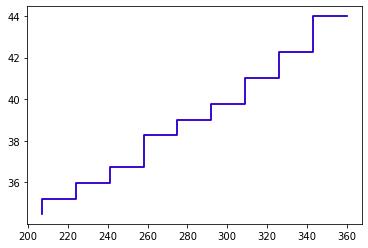

In [554]:
plt.plot(example['Energy_tot'][1:-1], example_y_pred_rf[1:-1], drawstyle='steps', 
         label='steps (=steps-pre)', color='red')

plt.plot(example['Energy_tot'][1:-1], example_y[1:-1], drawstyle='steps', 
         label='steps (=steps-pre)', color='blue')

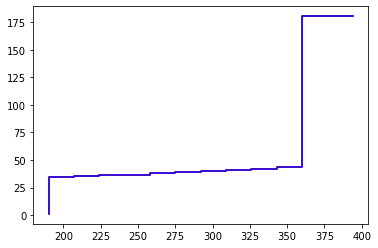

In [555]:
#We can observe that with dt first and last price are very good predicted

plt.plot(example['Energy_tot'], example_y_pred_rf, drawstyle='steps', 
         label='steps (=steps-pre)', color='red')

plt.plot(example['Energy_tot'], example_y, drawstyle='steps', 
         label='steps (=steps-pre)', color='blue')

## REGRESSION MODELS

In [508]:
## LINEAR REGRESSION

from sklearn.linear_model import LinearRegression

#Creation of a model instance 
reg_linear = LinearRegression()

reg_linear.fit(X_train,y_train)


LinearRegression()

In [509]:
y_pred_linear = reg_linear.predict(X_test)

In [510]:
reg_linear.coef_

array([-5.89848090e+11, -5.89848090e+11, -5.89848090e+11, -5.89848090e+11,
       -5.89848090e+11, -5.89848090e+11, -5.89848090e+11, -5.89848090e+11,
       -5.89848090e+11, -5.89848090e+11, -5.89848090e+11, -5.89848090e+11,
       -7.72669967e+11, -7.72669967e+11, -7.72669967e+11, -7.72669967e+11,
       -7.72669967e+11, -7.72669967e+11, -7.72669967e+11, -7.72669967e+11,
       -7.72669967e+11, -7.72669967e+11, -7.72669967e+11, -7.72669967e+11,
       -7.72669967e+11, -7.72669967e+11, -7.72669967e+11, -7.72669967e+11,
       -7.72669967e+11, -7.72669967e+11, -7.72669967e+11, -7.72669967e+11,
       -7.72669967e+11, -7.72669967e+11, -7.72669967e+11, -7.72669967e+11,
       -7.72669967e+11, -7.72669967e+11, -7.72669967e+11, -7.72669967e+11,
       -7.72669967e+11, -7.72669967e+11, -7.72669967e+11,  1.14641899e+13,
        1.14641899e+13,  1.14641899e+13,  1.14641899e+13,  1.14641899e+13,
        1.14641899e+13,  1.14641899e+13,  1.14641899e+13,  1.14641899e+13,
        1.14641899e+13,  

In [511]:
#MAE metric
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_test,y_pred_linear) # Primero valor real y luego prediccion

18.416656348270443

In [147]:
## K-NEIGHBORS REGRESSION

#from sklearn.neighbors import KNeighborsRegressor

In [150]:
#reg_kneig = KNeighborsRegressor(n_neighbors=10)

#reg_kneig.fit(X_train,y_train)


KNeighborsRegressor(n_neighbors=10)

In [151]:
#y_pred_kneig = reg_kneig.predict(X_test)


In [152]:
# MAE
#mean_absolute_error(y_test,y_pred_kneig)

0.3730708008155806

In [68]:
# RMSE from linear regression

from sklearn.metrics import mean_squared_error

np.sqrt(mean_squared_error(y_test,y_pred_linear))

2.9004693431312716

In [154]:
# RMSE: k Nei
#np.sqrt(mean_squared_error(y_test,y_pred_kneig))

0.7570955998489847

In [512]:


## X-validation for linear regression

from sklearn.model_selection import cross_val_score

#X-val for LINEAR REGRESSION
#cv=5 (by default)

cross_val_score(reg_linear,X,y,scoring="neg_mean_absolute_error")

array([-1.01808282e+14, -1.79309358e+13, -1.03239382e+12, -2.26091210e+12,
       -2.83432241e+12])

In [513]:
#NO ENTIENDO QUÉ ESTÁ PASANDO AQUÍ... ¿CÓMO ES POSIBLE QUE PRIMERO SALGA DEL ORDEN DE 2 Y LUEGO DEL ORDEN DE 2e12?

In [514]:
cross_val_score(reg_linear,X,y,scoring="neg_mean_absolute_error").mean()

-25173369218084.83

In [158]:
#X-val for K-NEIGHBORS
#cross_val_score(reg_kneig,X,y,scoring="neg_mean_absolute_error")

array([-4.98565275, -3.93704078, -3.59623646, -1.19427415, -3.42797405])

In [159]:
#############################################################################################################

In [160]:
#Examples of real and predition curves will be ploted to compare them.

<ipython-input-38-ece397bd5943>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_plot = df_curve.sort_values(['Date','Period','Block'])[(df_curve['Date'] == date) &


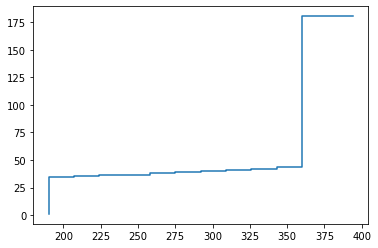

In [81]:
plot_bid_curve('2020-8-16',18)

In [516]:
example = df_tot.sort_values(['Date','Period','Block'])[(df_tot['Date']=='2020-08-16') & 
                                                (df_tot['Period']==18)]
example

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
79776,394.10,2020,8,16,18,1,1.13,190.00,2020-08-16,Sunday,190.00
79777,394.10,2020,8,16,18,2,34.48,17.00,2020-08-16,Sunday,207.00
79778,394.10,2020,8,16,18,3,35.22,17.00,2020-08-16,Sunday,224.00
79779,394.10,2020,8,16,18,4,35.97,17.00,2020-08-16,Sunday,241.00
79780,394.10,2020,8,16,18,5,36.72,17.00,2020-08-16,Sunday,258.00
79781,394.10,2020,8,16,18,6,38.26,17.00,2020-08-16,Sunday,275.00
79782,394.10,2020,8,16,18,7,39.01,17.00,2020-08-16,Sunday,292.00
79783,394.10,2020,8,16,18,8,39.76,17.00,2020-08-16,Sunday,309.00
79784,394.10,2020,8,16,18,9,41.00,17.00,2020-08-16,Sunday,326.00
79785,394.10,2020,8,16,18,10,42.25,17.00,2020-08-16,Sunday,343.00


In [517]:
example_cat = example[['Month','Day','Period','Weekday','Block']]
example_cat

,Month,Day,Period,Weekday,Block
79776,8,16,18,Sunday,1
79777,8,16,18,Sunday,2
79778,8,16,18,Sunday,3
79779,8,16,18,Sunday,4
79780,8,16,18,Sunday,5
79781,8,16,18,Sunday,6
79782,8,16,18,Sunday,7
79783,8,16,18,Sunday,8
79784,8,16,18,Sunday,9
79785,8,16,18,Sunday,10


In [518]:
# example transformation to predict only this sample.
example_cat_onehot = one_encoder.transform(example_cat)
example_cat_onehot.shape

(12, 87)

In [519]:
example_cat_onehot

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [520]:
example_energy = np.asarray(example[['Energy_tot']]/example['Energy_tot'].max())
example_energy

array([[0.48211114],
       [0.5252474 ],
       [0.56838366],
       [0.61151992],
       [0.65465618],
       [0.69779244],
       [0.7409287 ],
       [0.78406496],
       [0.82720122],
       [0.87033748],
       [0.91347374],
       [1.        ]])

In [521]:
example_X = np.concatenate((example_cat_onehot, example_energy), axis=1)

In [522]:
example_y = np.asarray(example['Price'])

In [523]:
#Example with linear regression

example_y_pred_linear = reg_linear.predict(example_X)

In [524]:
example_y_pred_linear

array([-26.140625 ,  35.3125   ,  37.21875  ,  38.9375   ,  40.7265625,
        47.0078125,  50.3125   ,  52.09375  ,  53.8203125,  55.921875 ,
        58.296875 , 142.7890625])

In [525]:
example_y

array([  1.13,  34.48,  35.22,  35.97,  36.72,  38.26,  39.01,  39.76,
        41.  ,  42.25,  43.99, 180.3 ])

<ipython-input-402-ece397bd5943>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_plot = df_curve.sort_values(['Date','Period','Block'])[(df_curve['Date'] == date) &


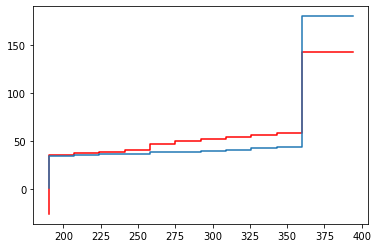

In [526]:
plt.plot(example['Energy_tot'], example_y_pred_linear, drawstyle='steps', label='steps (=steps-pre)', color='red')
plot_bid_curve('2020-8-16',18)

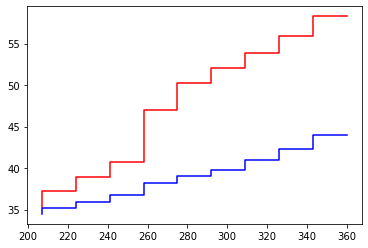

In [527]:
plt.plot(example['Energy_tot'][1:-1], example_y_pred_linear[1:-1], drawstyle='steps', 
         label='steps (=steps-pre)', color='red')

plt.plot(example['Energy_tot'][1:-1], example_y[1:-1], drawstyle='steps', 
         label='steps (=steps-pre)', color='blue')

In [95]:
#Example with k-neighbors regression

#example_y_pred_kneig = reg_kneig.predict(example_X)

In [96]:
#example_y_pred_kneig

In [97]:
example_y

array([  1.13,  34.48,  35.22,  35.97,  36.72,  38.26,  39.01,  39.76,
        41.  ,  42.25,  43.99, 180.3 ])

In [98]:
#plt.plot(example['Energy_tot'], example_y_pred_kneig, drawstyle='steps', label='steps (=steps-pre)', color='red')
#plot_bid_curve('2020-8-16',18)

In [99]:
#plt.plot(example['Energy_tot'][1:-1], example_y_pred_kneig[1:-1], drawstyle='steps', 
#         label='steps (=steps-pre)', color='red')

#plt.plot(example['Energy_tot'][1:-1], example_y[1:-1], drawstyle='steps', 
#         label='steps (=steps-pre)', color='blue')

In [179]:
#Tiene pinta de que el primer precio es muy variable porque lo calcula muy mal. 
#Esto es debido a que no todas las segmentaciones de las horas son iguales por lo que ese primer valor puede no
#estar bien estimado. 
#POSIBLE ARREGLO: dividir todas las horas en un mismo número de bloques (12, por ejemplo), asignando un mismo
#valor de energía a todos los segmentos nuevos --> ¿relación con la predicción de dos variables?

In [180]:
##########################################################################################################


In [528]:
#DECISION TREES

from sklearn.tree import DecisionTreeRegressor

reg_dt = DecisionTreeRegressor(max_depth=3, min_samples_leaf=5)

reg_dt.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=3, min_samples_leaf=5)

In [529]:
y_pred_dt = reg_dt.predict(X_test)

In [530]:
# MAE
mean_absolute_error(y_test,y_pred_dt)

37.79993984950459

In [532]:
# RMSE from decision trees
from sklearn.metrics import mean_squared_error

np.sqrt(mean_squared_error(y_test,y_pred_dt))

53.62519783513704

In [533]:
#Example with decision tree regression

example_y_pred_dt = reg_dt.predict(example_X)

In [534]:
example_y_pred_dt

array([ 65.58129086,  65.58129086,  65.58129086,  65.58129086,
        65.58129086,  65.58129086,  65.58129086,  65.58129086,
        65.58129086,  65.58129086,  65.58129086, 180.3       ])

In [535]:
example_y

array([  1.13,  34.48,  35.22,  35.97,  36.72,  38.26,  39.01,  39.76,
        41.  ,  42.25,  43.99, 180.3 ])

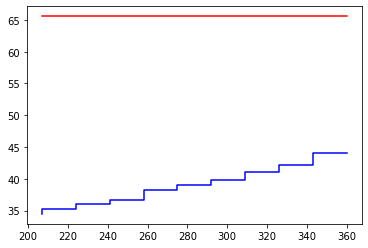

In [536]:
plt.plot(example['Energy_tot'][1:-1], example_y_pred_dt[1:-1], drawstyle='steps', 
         label='steps (=steps-pre)', color='red')

plt.plot(example['Energy_tot'][1:-1], example_y[1:-1], drawstyle='steps', 
         label='steps (=steps-pre)', color='blue')

In [537]:
#It seems that this decision tree is not good. In order to optimize the dt regression, GridSearchCV is tried.
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

reg_gdt = GridSearchCV(DecisionTreeRegressor(),
                      param_grid={"max_depth":np.arange(2,11),
                                  "min_samples_leaf":np.arange(10,100,15)},
                      scoring="neg_mean_absolute_error")
reg_gdt.fit(X_train,y_train)

GridSearchCV(estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'min_samples_leaf': array([10, 25, 40, 55, 70, 85])},
             scoring='neg_mean_absolute_error')

In [538]:
reg_gdt.best_params_

{'max_depth': 10, 'min_samples_leaf': 10}

In [539]:
y_pred_gdt = reg_gdt.predict(X_test)

In [540]:
# MAE
mean_absolute_error(y_test,y_pred_gdt)

7.35043618761412

In [541]:
# RMSE from decision trees

np.sqrt(mean_squared_error(y_test,y_pred_gdt))

20.663697346452288

In [542]:
#Example with grid decision tree regression

example_y_pred_gdt = reg_gdt.predict(example_X)

In [543]:
example_y_pred_gdt

array([ 39.53746396,  39.53746396,  39.53746396,  39.53746396,
        39.53746396,  39.53746396,  39.53746396,  39.53746396,
        39.53746396,  39.53746396,  39.53746396, 180.3       ])

In [544]:
example_y

array([  1.13,  34.48,  35.22,  35.97,  36.72,  38.26,  39.01,  39.76,
        41.  ,  42.25,  43.99, 180.3 ])

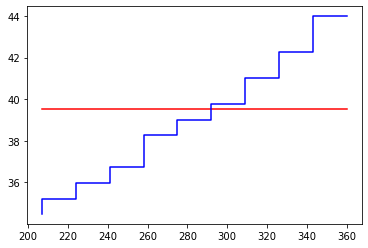

In [545]:
plt.plot(example['Energy_tot'][1:-1], example_y_pred_gdt[1:-1], drawstyle='steps', 
         label='steps (=steps-pre)', color='red')

plt.plot(example['Energy_tot'][1:-1], example_y[1:-1], drawstyle='steps', 
         label='steps (=steps-pre)', color='blue')

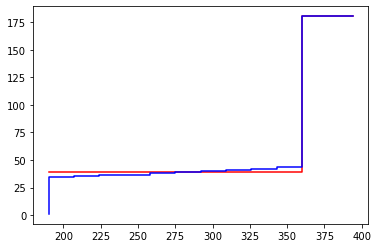

In [546]:
#We can observe that with dt first and last price are very good predicted

plt.plot(example['Energy_tot'], example_y_pred_gdt, drawstyle='steps', 
         label='steps (=steps-pre)', color='red')

plt.plot(example['Energy_tot'], example_y, drawstyle='steps', 
         label='steps (=steps-pre)', color='blue')

In [556]:
#XG-BOOST

from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [557]:
reg_XGB = GradientBoostingRegressor(max_depth=4, n_estimators=100,learning_rate=0.1)

In [558]:
reg_XGB.fit(X_train,y_train)

GradientBoostingRegressor(max_depth=4)

In [559]:
y_pred_XGB = reg_XGB.predict(X_test)

In [560]:
#MAE
mean_absolute_error(y_test,y_pred_XGB)

5.701508052720888

In [561]:
# RMSE
np.sqrt(mean_squared_error(y_test,y_pred_XGB))

9.910589982121671

In [562]:
cross_val_score(reg_XGB,X,y,scoring="neg_mean_absolute_error").mean()

-6.422621057315814

In [563]:
from sklearn.model_selection import GridSearchCV

reg_XGB_CV = GridSearchCV(GradientBoostingRegressor(n_estimators=50),
                  param_grid={"max_depth":np.arange(2,10),
                             "learning_rate":np.arange(1,10)/10},
                  scoring="neg_mean_absolute_error",
                  cv=5)

In [564]:
reg_XGB_CV.fit(X,y)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(n_estimators=50),
             param_grid={'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'max_depth': array([2, 3, 4, 5, 6, 7, 8, 9])},
             scoring='neg_mean_absolute_error')

In [565]:
reg_XGB_CV.best_params_

{'learning_rate': 0.4, 'max_depth': 9}

In [566]:
y_pred_XGB_CV = reg_XGB_CV.predict(X_test)

In [567]:
# MAE
mean_absolute_error(y_test,y_pred_XGB_CV)

0.39593423435237785

In [568]:
# RMSE from random forest

np.sqrt(mean_squared_error(y_test,y_pred_XGB_CV))

0.6609829575219727